# Image study of the patterns and how best to insert them into the CNNs

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import pandas as pd
from random import randrange

###Conect to drive

In [3]:
# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Mounted at /content/drive


# Utils

In [8]:
""" 
This code is intended for the visualization of large images 
"""
# If you are in colab set colaboratory AND notebook to True
# if you are locally in a notebook set colbaoratory to False
# and install bokeh yourself
# If you are using the script on a local machine not in a notebook
# set both to False 
notebook=True
colaboratory=True
if notebook:
    from IPython.display import Audio
    if colaboratory:
        !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    from bokeh.colors import Color as bcolor
    from bokeh.colors.rgb import RGB


import numpy as np

import matplotlib.pyplot as plt
import scipy 
from scipy.signal import lfilter
import scipy.io
import platform
import time

import tempfile
import os

def RGBtoYCrCb(im,ty='8bit'): 
    assert len(im.shape)==3 and im.shape[2]==3, 'image dans un mauvais format'
    if ty=='8bit':
        delta=128 #ce delta est simplement le milieu de la plage des valeurs 
                    # possibles. 
    out=np.empty(im.shape)
    Y=0.299*im[:,:,0]+0.587*im[:,:,1]+0.114*im[:,:,2]
    Cr=(im[:,:,0]-Y)*0.713+delta
    Cb=(im[:,:,2]-Y)*0.564+delta
    return (Y,Cr,Cb)



def YCrCbtoRGB(Y,Cr,Cb,ty='8bit'):
    delta=128
    out=np.empty([*Y.shape,3],dtype=np.float32)
    out[:,:,0]=Y+1.402*(Cr-delta)
    out[:,:,1]=Y-0.34414*(Cb-128)-0.71414*(Cr-128)
    out[:,:,2]=Y+1.772*(Cb-128)
    return out
    
import skimage.transform
if notebook:
  liste_couleurs_grises=[]
  for k in range(256):
    liste_couleurs_grises.append(RGB(k,k,k))
  def affiche_pour_colab(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''): #special colab, ne pas regarder
    def normalise_image_pour_bokeh(X,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
      Y=(X.copy())
      if len(Y.shape)==2: 
        Y=np.zeros((*Y.shape,3))
        for k in range(3):
          Y[:,:,k]=X.copy()
   
      if normalise:
        Y-=Y.min()
        Y/=Y.max()
        Y*=255
      else:
        Y-=MINI
        Y/=(MAXI-MINI)
        Y*=255

      Y=Y.astype(np.uint8)
      sortie=np.empty(Y.shape[:2],dtype=np.uint32)
      view=sortie.view(dtype=np.uint8).reshape((Y.shape[:2]+(4,)))
      for k in range(3):
        view[:,:,k]=Y[:,:,k]
      view[:,:,3]=255
      return sortie
    img=normalise_image_pour_bokeh(np.flipud(im),normalise=normalise,MINI=MINI,MAXI=MAXI)# np.flipud(np.fliplr(im)))
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
    p.x_range.range_padding = p.y_range.range_padding = 0

    # must give a vector of images
    p.image_rgba(image=[img],x=0,y=0, dw=im.shape[1], dh=im.shape[0])
    showbokeh(p)

  def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
      affiche_pour_colab(im,normalise=normalise,MINI=MINI, MAXI=MAXI,titre=titre) 
         # sous google colab beaucoup d''options disparaissent

else:
    def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
        """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image 
        resultat
        """
        imt=np.float32(im.copy())
        if platform.system()=='Darwin': #on est sous mac
            prephrase='open -a GIMP-2.10.app ' #certainement à adapter
            endphrase=' ' 
        else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment 
                                   #faire. Si vous savez dites-moi.)
            prephrase='gimp '
            endphrase= ' &'
    
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
    
        if titre!='':
            titre='_'+titre+'_'
        titre=titre.replace(' ','')
        nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
        commande=prephrase +nomfichier+endphrase
        skio.imsave(nomfichier,imt)
        os.system(commande)
        if printname:
            print(nomfichier)


if notebook:
    def plot(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif (len(argv)==1):
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: n'arriverait \
                pas hors de google colaboratory")
    
        p=figure()
        p.line(x,y)
        showbokeh(p)
    def stem(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif len(argv)==1:
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: \
                            n'arriverait pas hors de google colaboratory")

        p = figure()#title="simple line example", x_axis_label='x',
                    #y_axis_label='y')

        # add a line renderer with legend and line thickness
        p.segment(x,0,x, y, legend_label="Temp.", line_width=2)

        showbokeh(p)
    def show():
        return
else:
    plot=plt.plot
    stem=plt.stem
    show=plt.show # force l'affichage du graphique courant

def norm(X):
    return ((abs(X)**2).sum())**0.5
def read_image(fi):
    return np.float32(skio.imread(fi))

In [4]:
def size_hist(hist, n_classes, y_pattern_dict, percent=False):
  plt.subplots(n_classes//2+n_classes%2, 2, figsize=(15, 40))
  critical_out = []
  for i in range(n_classes):
    plt.subplot(n_classes//2+n_classes%2, 2, i+1)
    plt.hist(hist[i], 80)
    critical1 = np.quantile(hist[i], 0.95)
    plt.axvline(critical1, color='g', label=f'Critical:{int(critical1)}')
    if percent:
      critical2 = np.quantile(hist[i], 0.03)
    else:
      critical2 = np.quantile(hist[i], 0.05)
    plt.axvline(critical2, color='r', label=f'Critical:{int(critical2)}')
    plt.title(f'Pattern: {y_pattern_dict[i]}')
    plt.legend()
    critical_out.append((int(critical1), int(critical2)))
  plt.tight_layout()
  plt.show()
  return critical_out

In [5]:
def plot_cell_limiters(X, y, n_classes, y_pattern_dict, pixel_count, percentage):
  n_pixels = []
  emptyspace = []
  for i in range(n_classes):
    n_pixels.append([])
    emptyspace.append([])

  for i in range(len(X)):
    iclass = np.argmax(y[i])
    n = X[i].shape[0]*X[i].shape[1]
    n_pixels[iclass].append(n)
    emptyspace[iclass].append(100*np.count_nonzero(X[i]==0)/n)

  for i in range(n_classes):
    plt.figure(figsize=(15, 7))
    plt.title(f'Pattern {y_pattern_dict[i]}')
    plt.xlabel("number of pixels")
    plt.ylabel("% of pixels == 0")
    plt.axvline(pixel_count[i][0], color='r')
    plt.axvline(pixel_count[i][1], color='g')
    plt.axhline(percentage[i][0], color='b')
    plt.axhline(percentage[i][1], color='black')
    plt.scatter(n_pixels[i], emptyspace[i])
    plt.show()

In [6]:
def filter_db(X, y, pixel_count, percentage):
  #returns X and y in pixel_count and percentage of empty space
  Xl = []
  yl = []
  for i in range(len(X)):
    iclass = np.argmax(y[i])
    size = X[i].shape[0]*X[i].shape[1]
    percent = (100*np.count_nonzero(X[i]==0))/size
    if size < pixel_count[iclass][0] and size > pixel_count[iclass][1]:
      if percent < percentage[iclass][0] and percent > percentage[iclass][1]:
        Xl.append(X[i])
        yl.append(y[i])

  return np.array(Xl), np.array(yl)
  
def transform_square(X):
  #Images are currently cropped around the cell, this function makes all cells have a black square around them with the same
  #size with the size of their largest dimension
  Xcopy = X.copy()
  for i in range(len(X)):
    if X[i].shape[0] != X[i].shape[1]:
      max_dimension = max(X[i].shape[0],X[i].shape[1])
      aux = np.zeros((max_dimension, max_dimension))
      if max_dimension == X[i].shape[0]:
        margin = int((max_dimension - X[i].shape[1])/2)
        aux[:, margin: X[i].shape[1]+margin] = X[i]
      else:
        margin = int((max_dimension - X[i].shape[0])/2)
        aux[margin: X[i].shape[0]+margin, :] = X[i]
      Xcopy[i] = aux
  return Xcopy

def resize_square(X, cnn_input_size):
  # The resizing implemented is:
    # For smaller cells: no upscaling, just placing a smaller cell in a bigger black square
    # for bigger cells: downscaling
  Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
  for i in range(len(X)):
    if X[i].shape[0] < cnn_input_size:
      aux = np.zeros((cnn_input_size, cnn_input_size))
      margin = int((cnn_input_size - X[i].shape[0])/2)
      aux[margin: margin + X[i].shape[0], margin: margin + X[i].shape[0]] = X[i]
    elif X[i].shape[0] >= cnn_input_size:
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
    Xcopy[i] = np.asarray(aux, 'float32')
  return Xcopy

# Classified images

In [ ]:
pattern_folder = "/content/drive/MyDrive/Images/Cells/Cells_ images"
print('Importing...')

# y_pattern_dict is a vector that translates the position of the one-hot-encoder array to the pattern number observed in the folders
        # Example:
        # if 25 is at position 0, it means that an image with an output of [1 0 0...] is classified as being from pattern 25
n_classes = len(sorted(glob.glob(pattern_folder + '/*')))
y_pattern_dict = ["" for i in range(n_classes)]

X = np.array([]) #dataset
y = []
n_divs = 10

hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
hist_largest_dimension = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern
hist_percentage = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern

i = 0
for pattern_number_path in sorted(glob.glob(pattern_folder + '/*')): #iterating in every pattern
  pattern_number = pattern_number_path[len(pattern_folder)+1:] #Number of pattern
  y_pattern_dict[i] = pattern_number 
  print(pattern_number)
  for np_cells in sorted(glob.glob(pattern_number_path + '/*')):#iterating for every numpy array
    a = np.load(np_cells, allow_pickle=True) #gets array from drive
    # One hot encoder
    auxy = np.zeros(n_classes)
    auxy[i] = 1
    for j in range(len(a)):
      y.append(auxy)
    X = np.append(X, a)
    #histogram construction and segregation into best images
    for img in a:
      # segregation by percentage
      numzeros = (img == 0).sum()
      numnot = (img != 0).sum()
      div = min(((numnot*100/(numnot+numzeros))//10), n_divs-1)
      
      # segregation by area size
      size = img.shape[0]*img.shape[1]
      div = min(size//250, n_divs-1)

      # histograms 
      size = img.shape[0]*img.shape[1]
      hist_pixel_count[i].append(size)
      hist_largest_dimension[i].append(max(img.shape[0], img.shape[1]))
      hist_percentage[i].append(100*np.count_nonzero(img==0)/size)

  i += 1
hist_largest_dimension = np.asarray(hist_largest_dimension)
mean_nucleus_diameter = [np.mean(nuc) for nuc in hist_largest_dimension]

y = np.array(y)


### Plot histograms of pixels

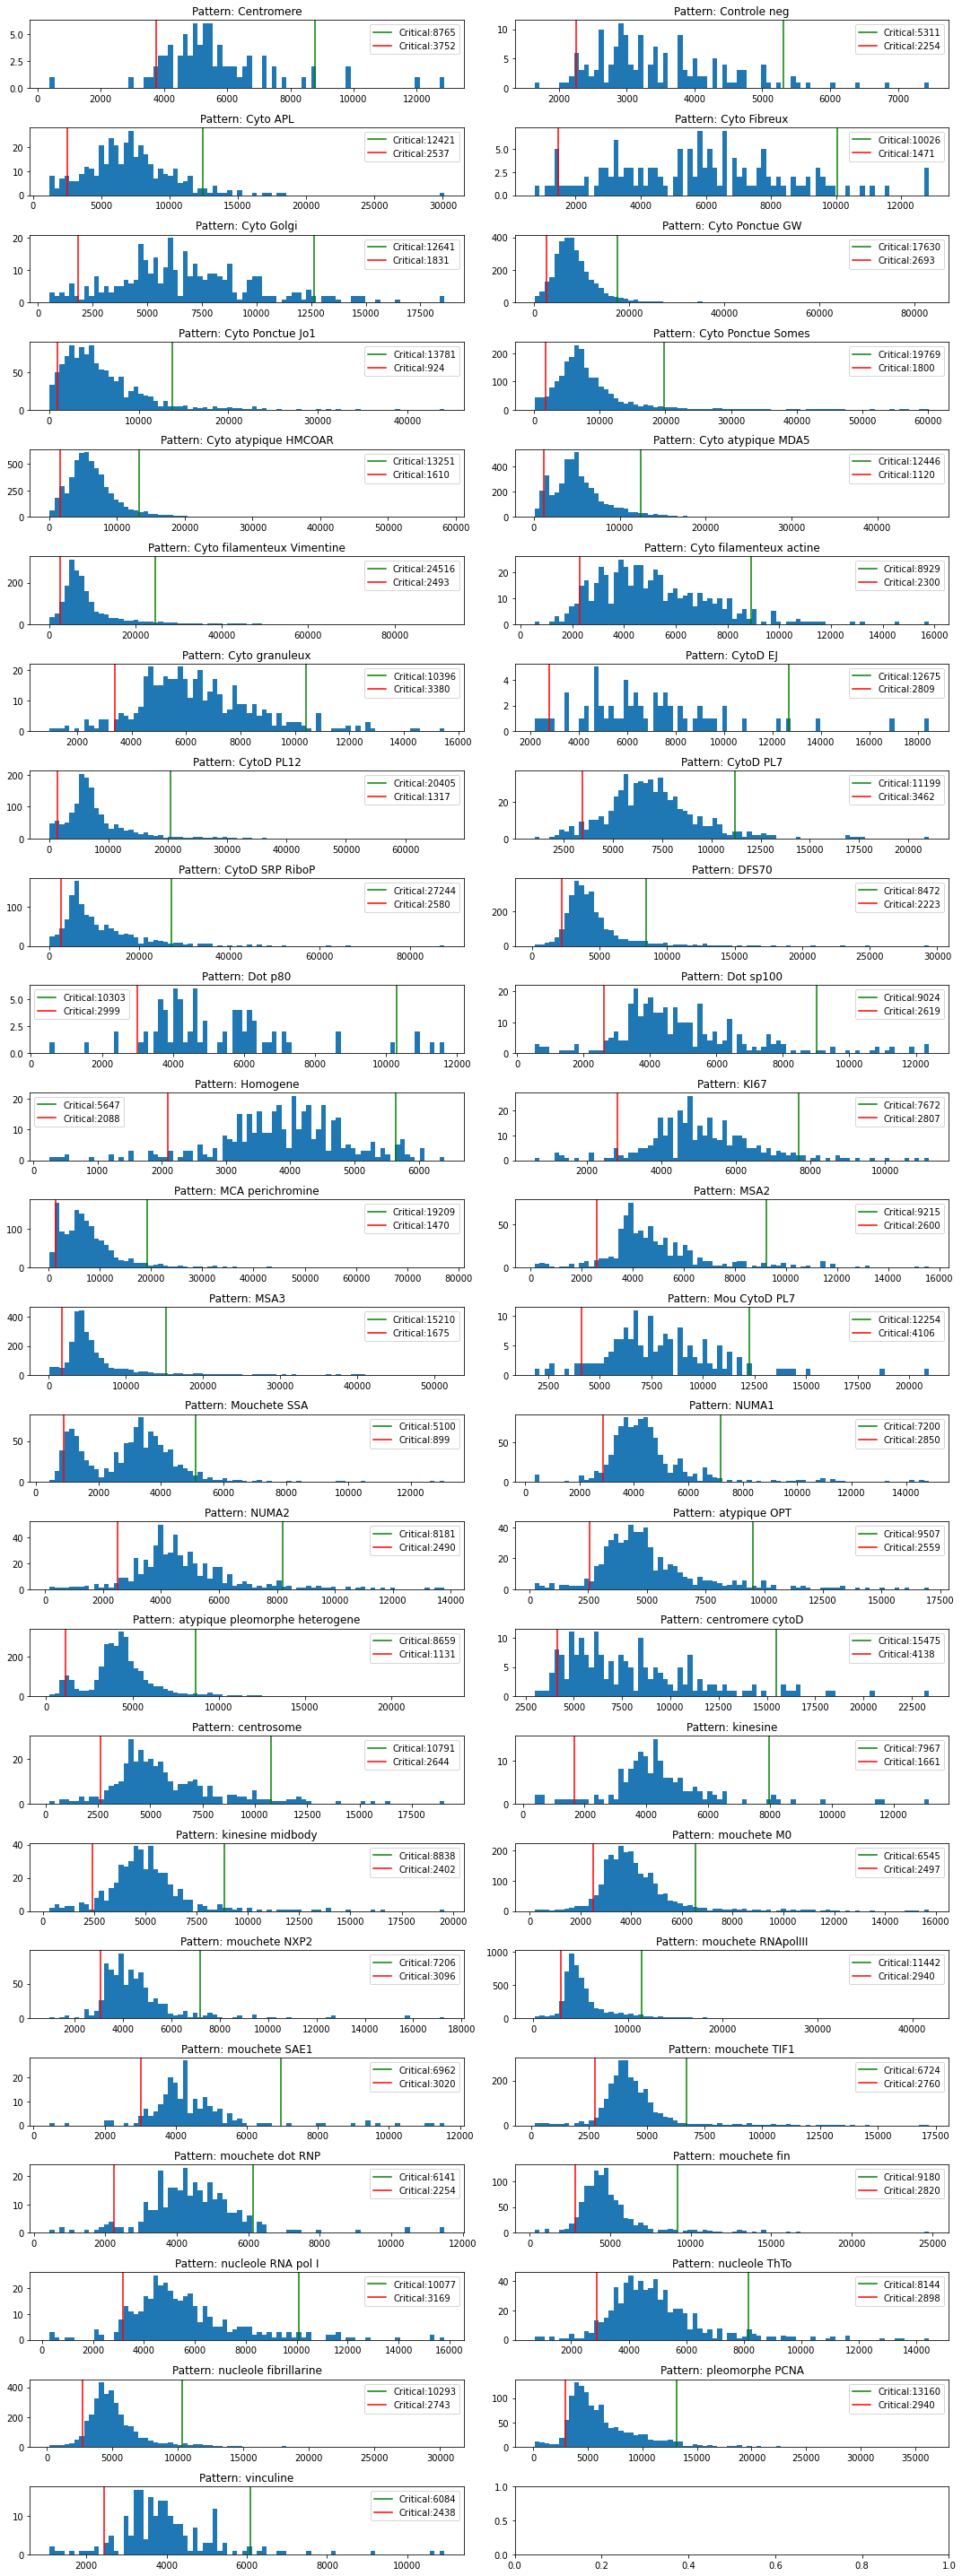

In [ ]:
pixel_count_parameters = size_hist(hist_pixel_count, n_classes, y_pattern_dict)

### Plot largest dimension histogram

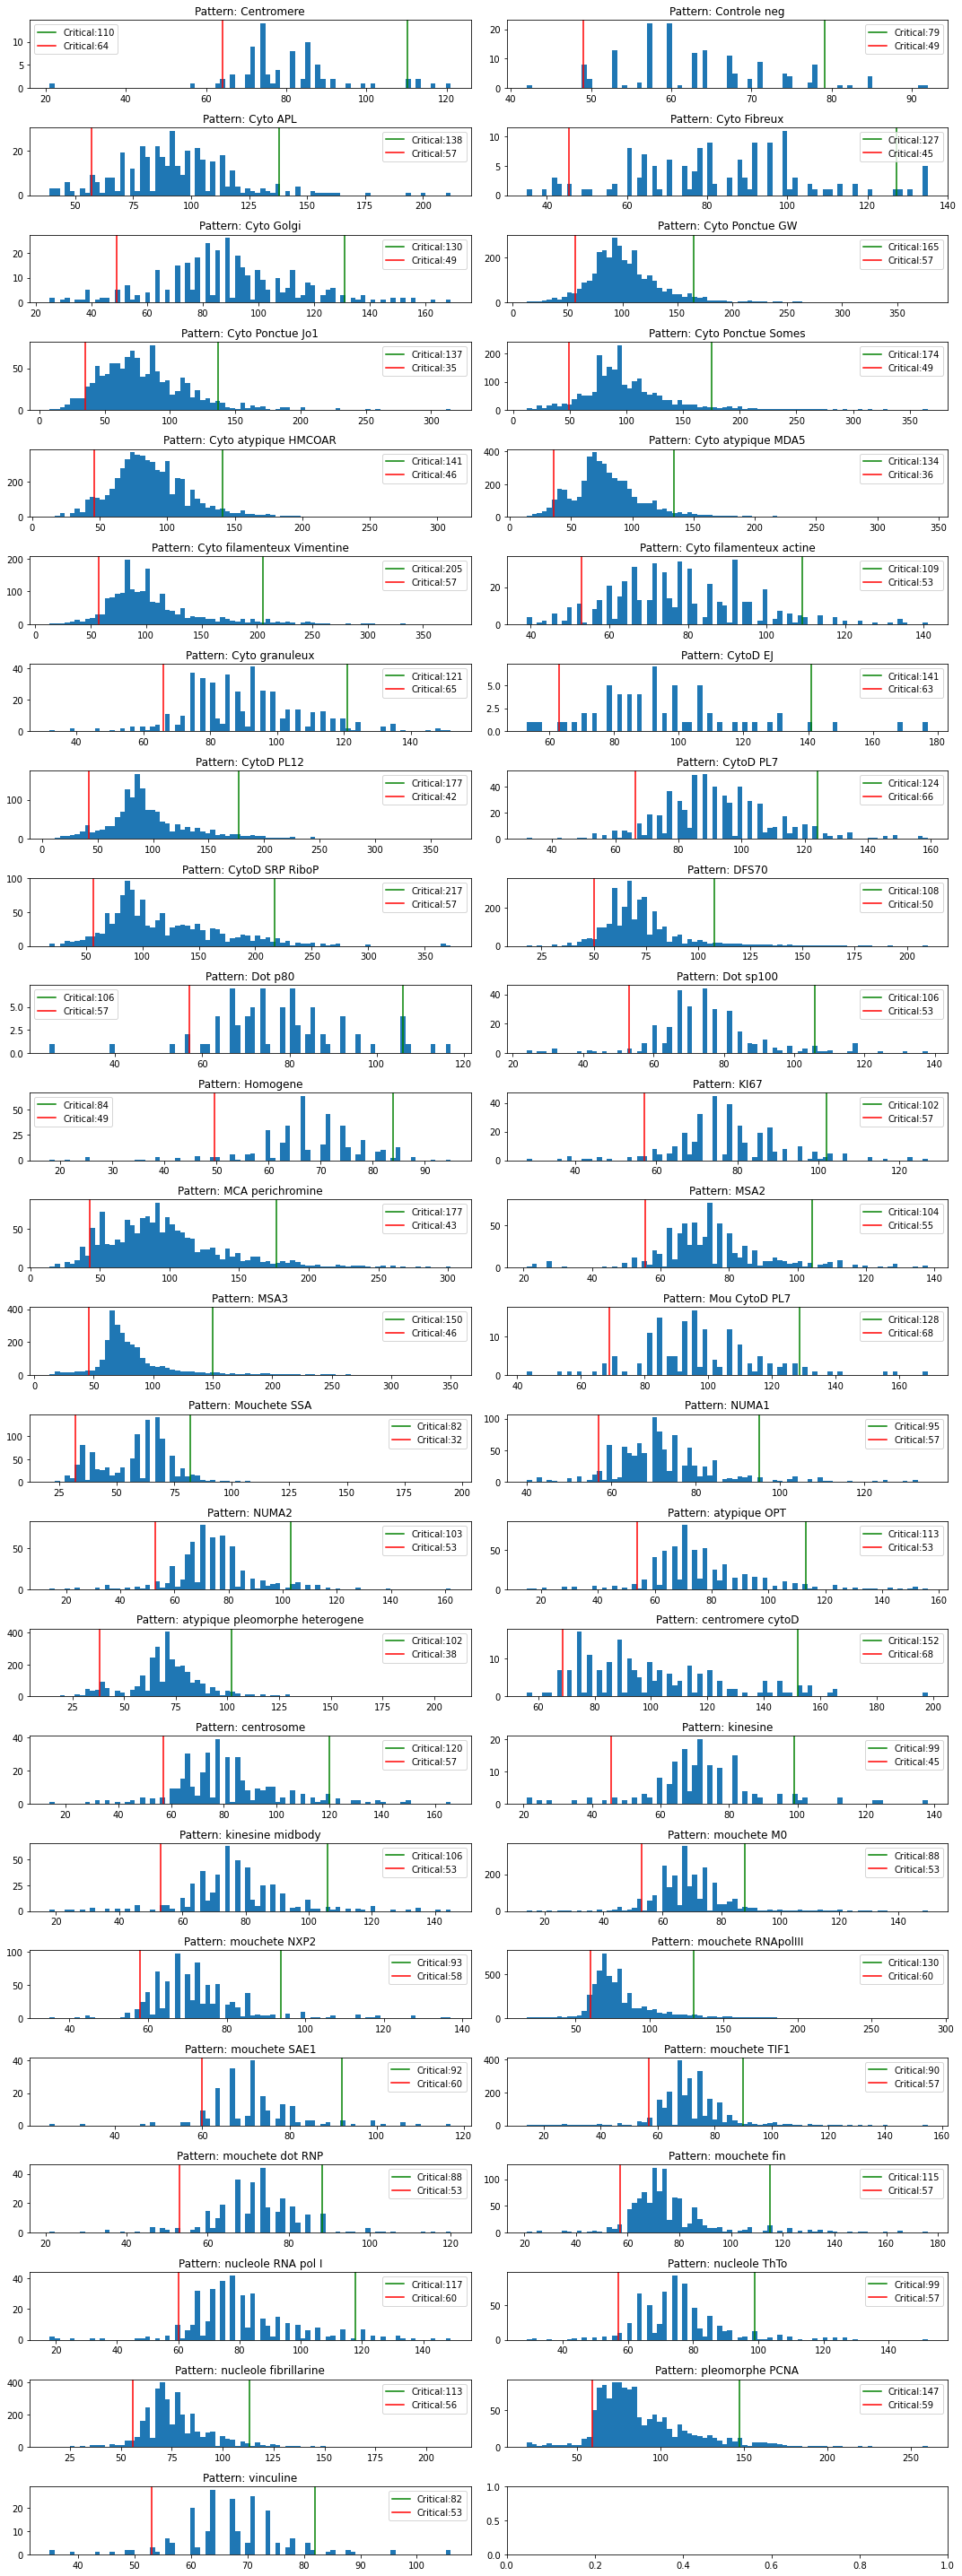

In [ ]:
largest_dimension_parameters = size_hist(hist_largest_dimension, n_classes, y_pattern_dict)

## By percentage of black pixels

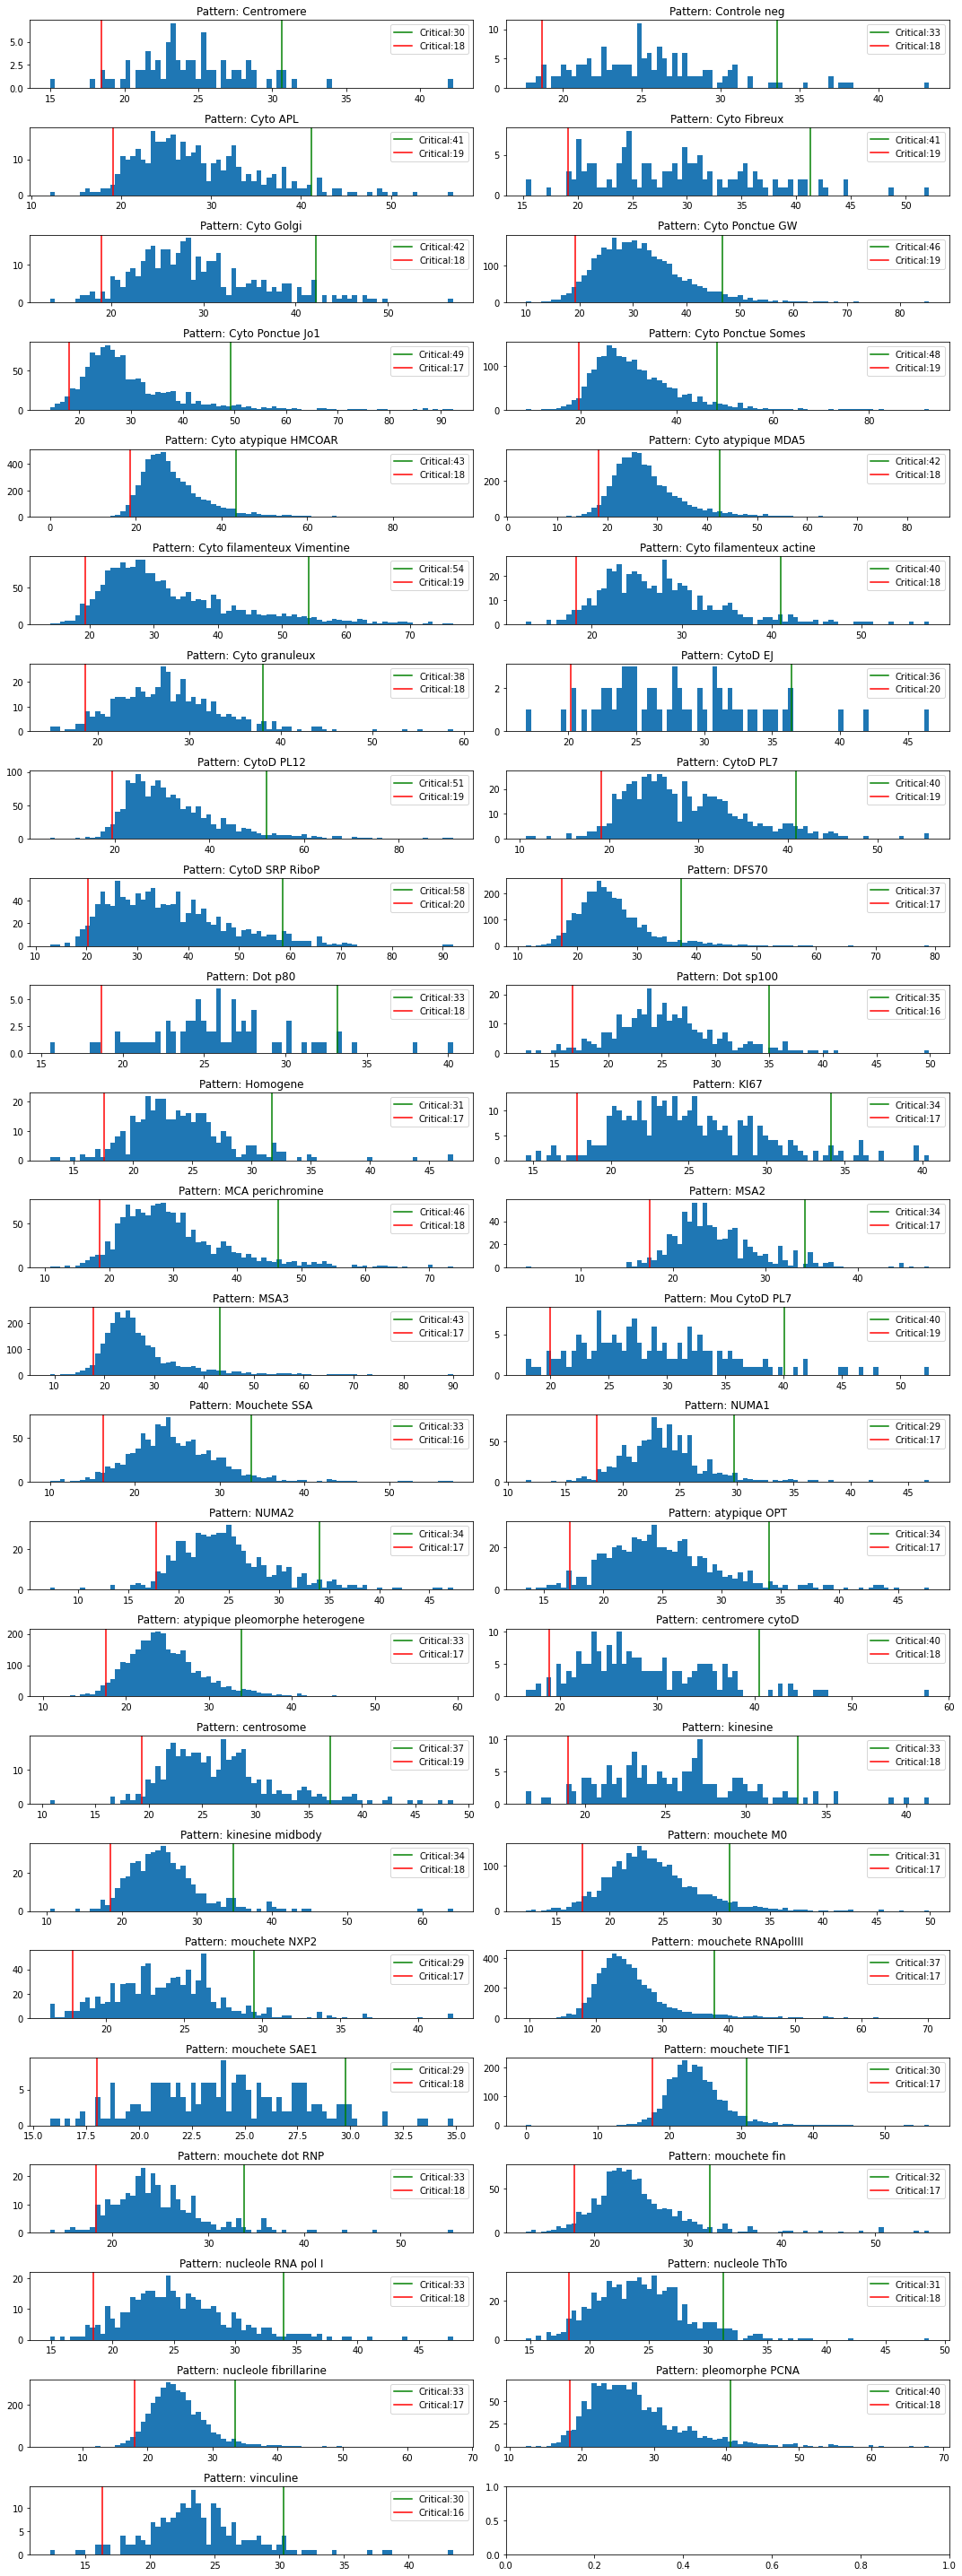

In [ ]:
percentage_parameters = size_hist(hist_percentage, n_classes, y_pattern_dict, True)

### Plot filtering by porcentage and size of cells

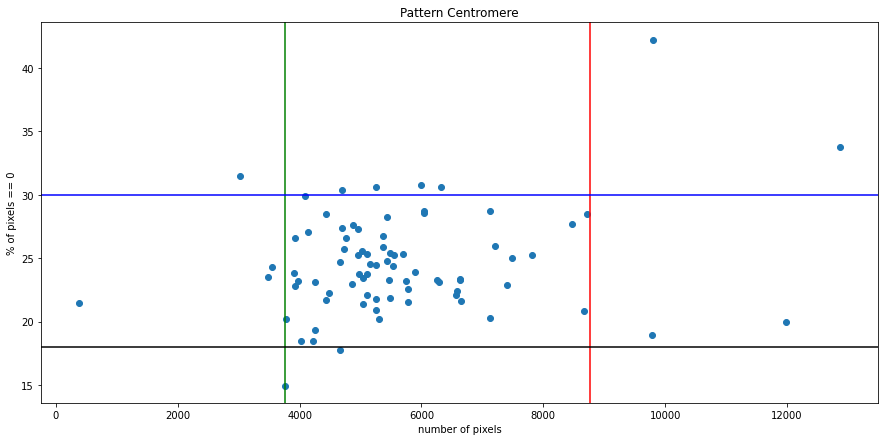

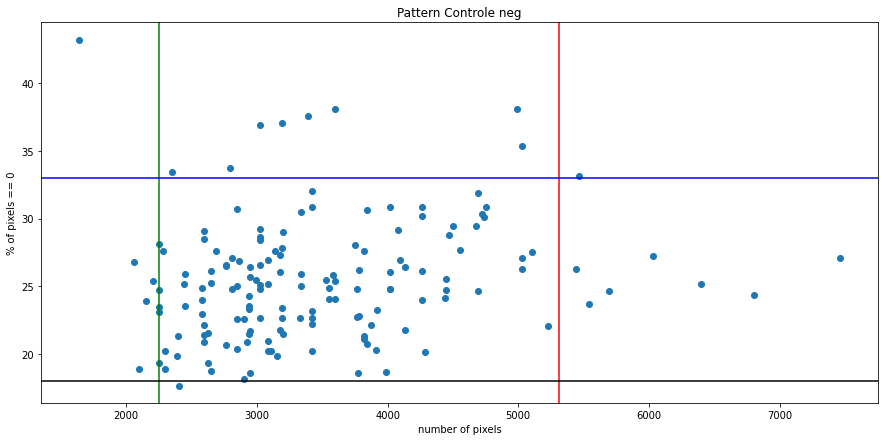

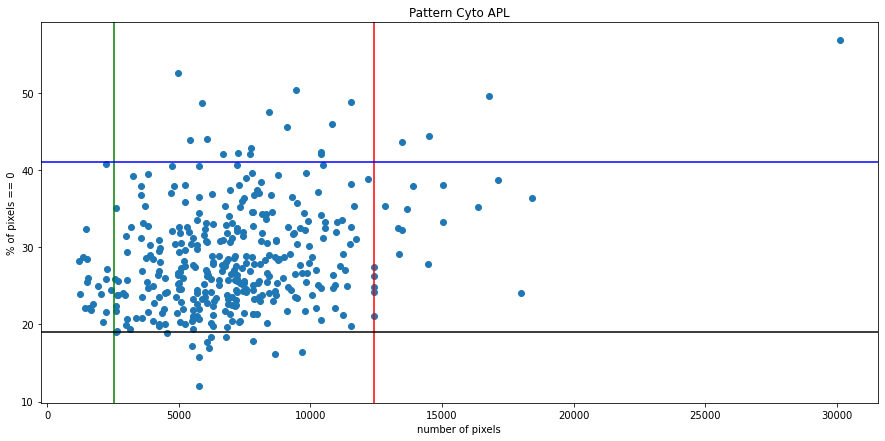

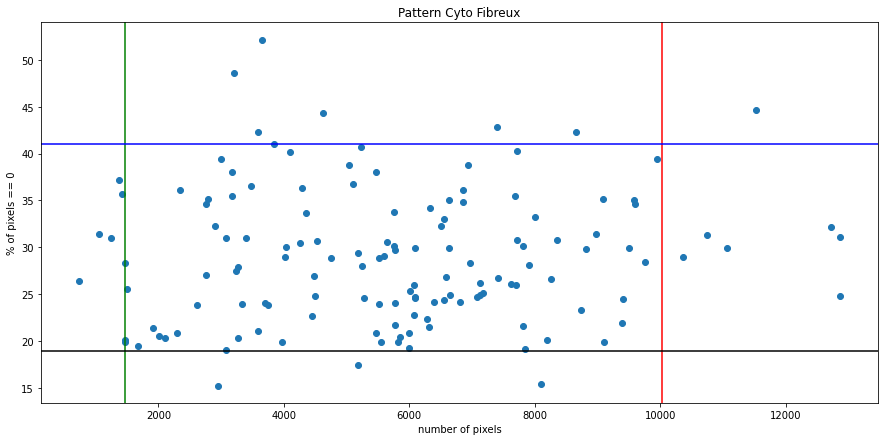

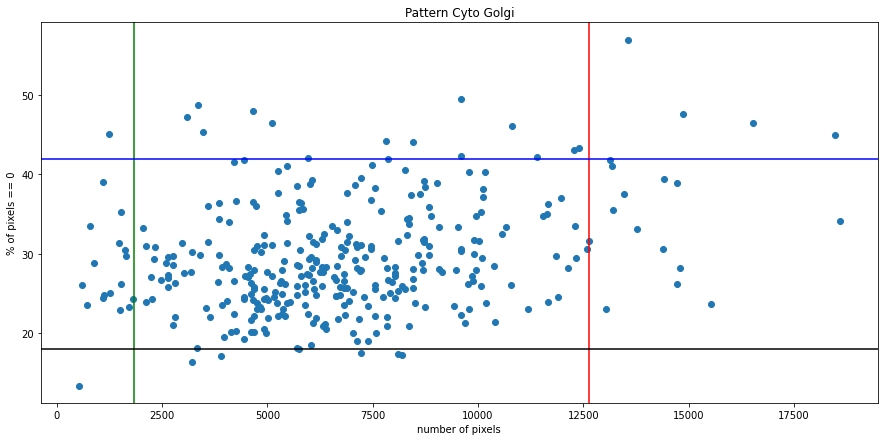

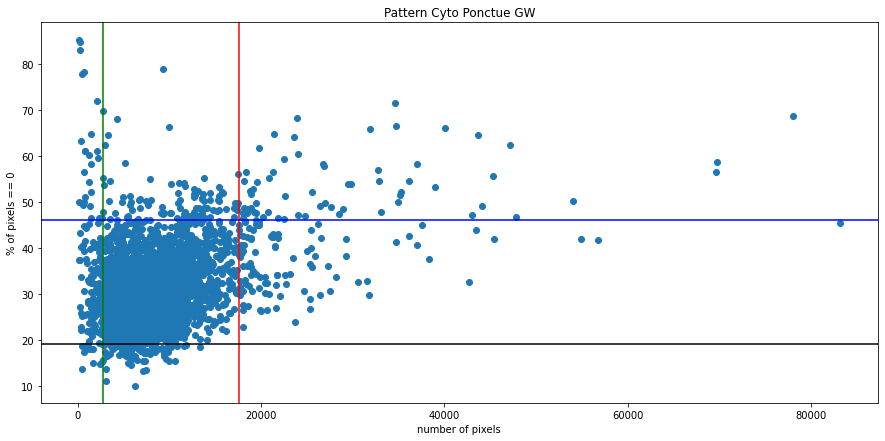

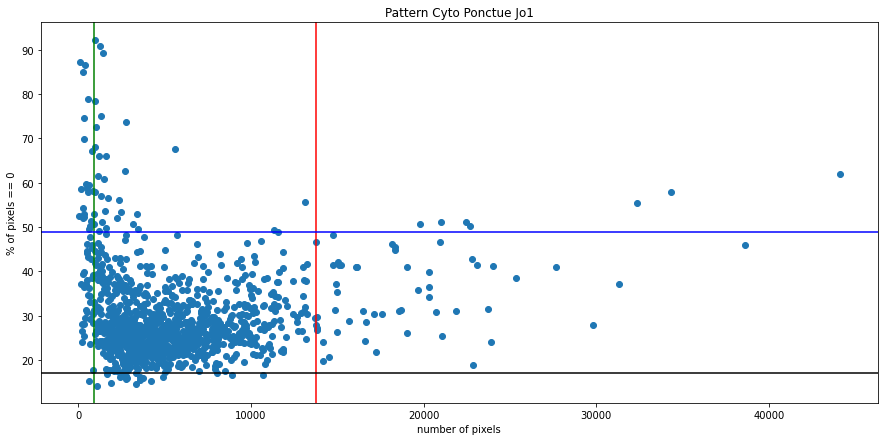

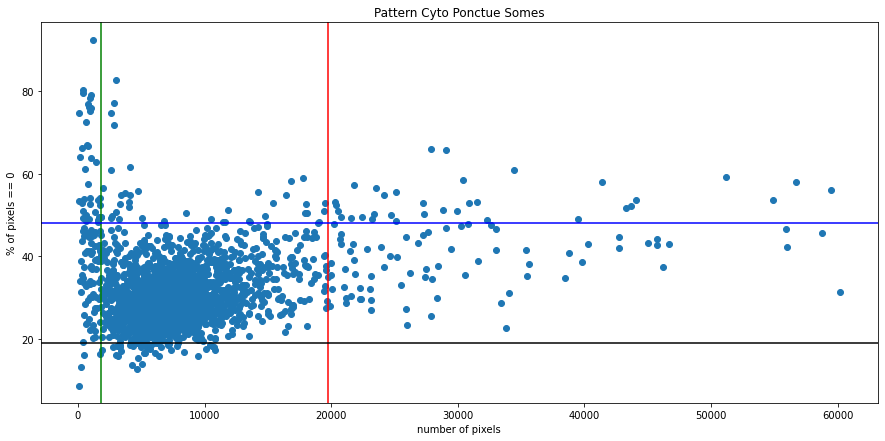

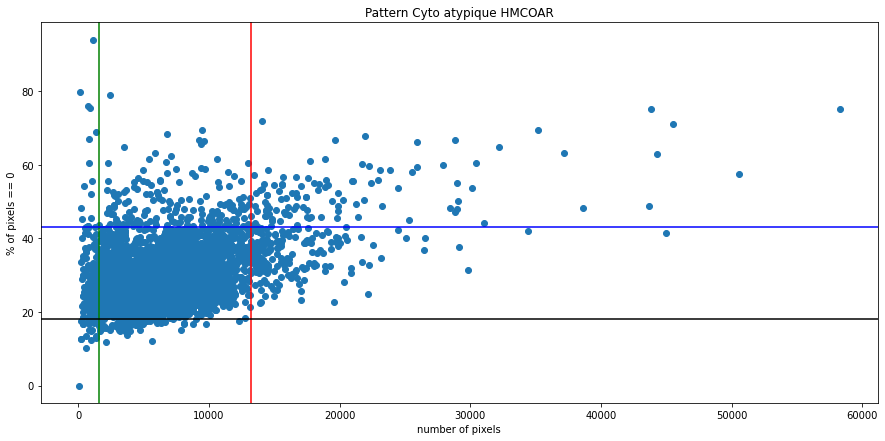

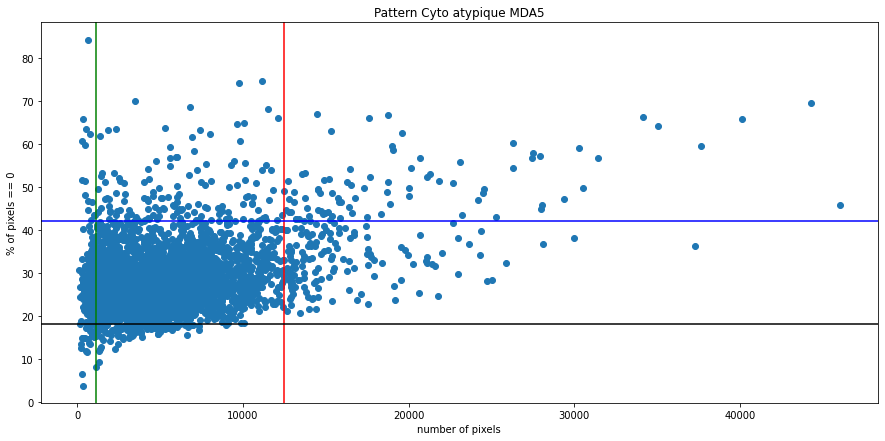

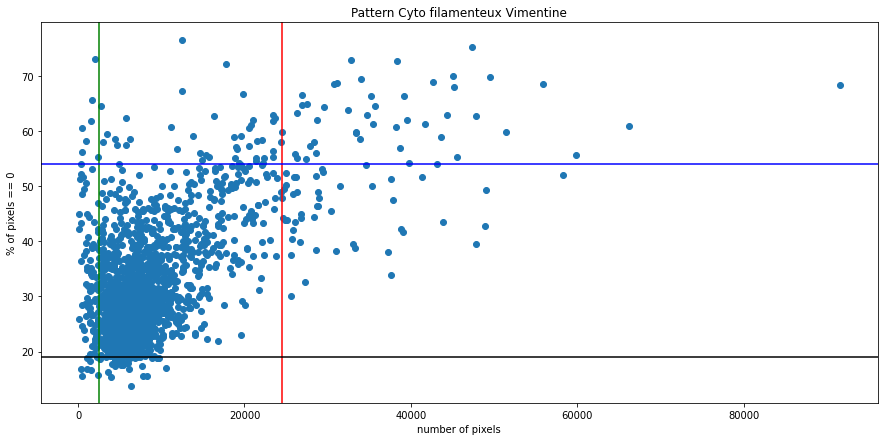

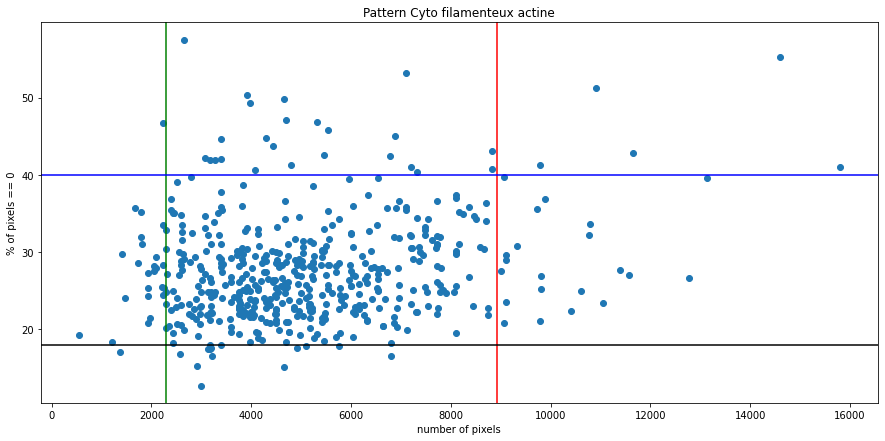

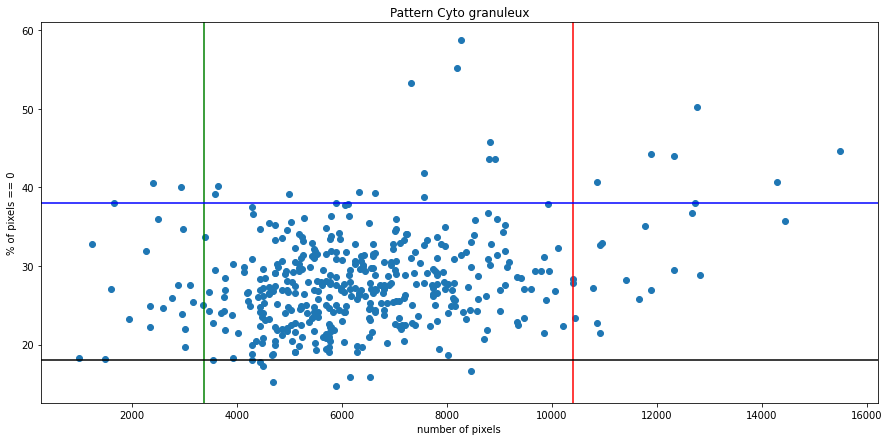

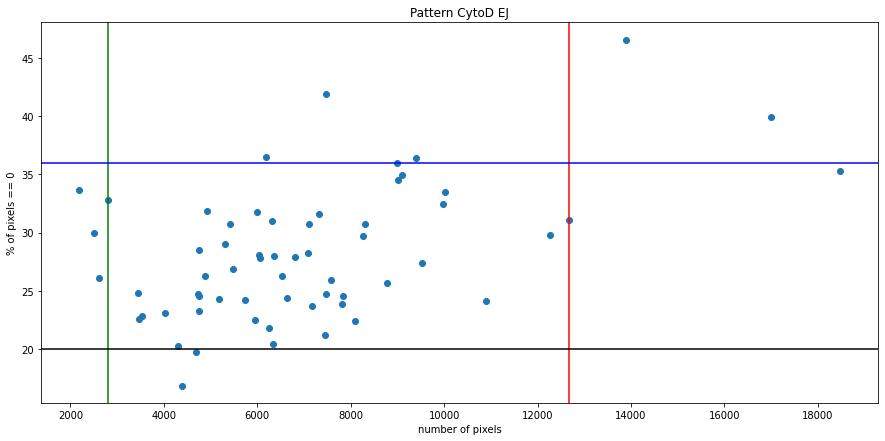

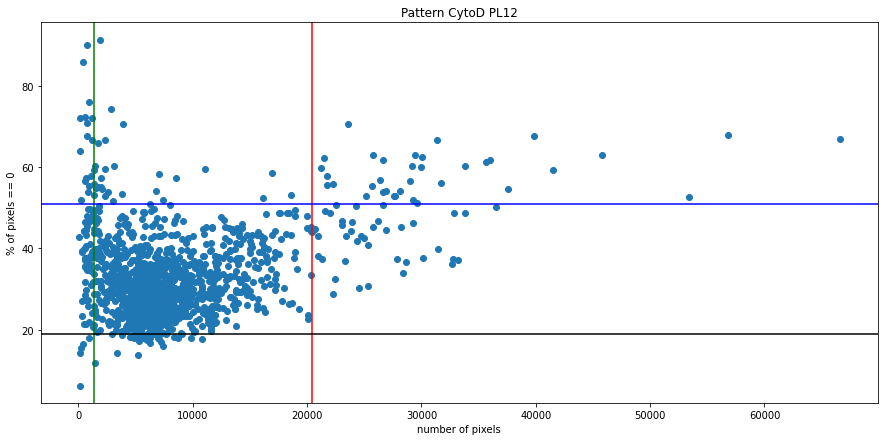

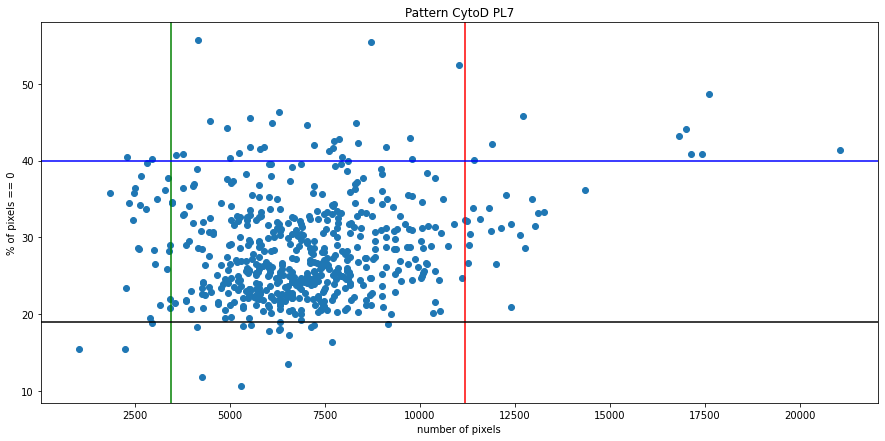

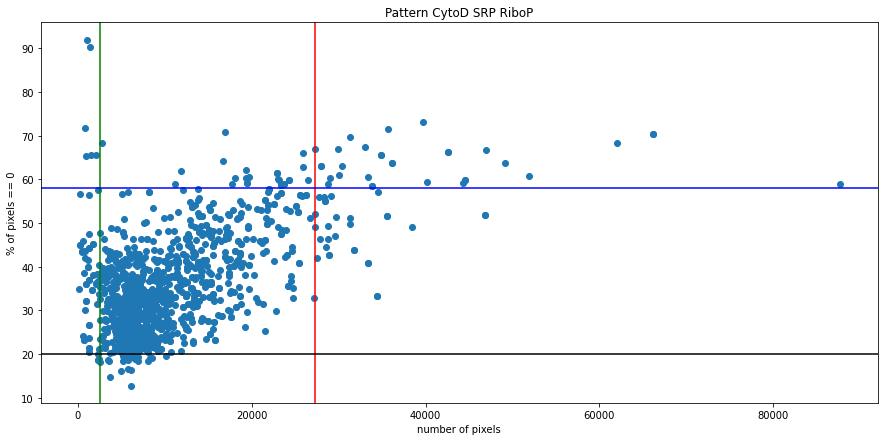

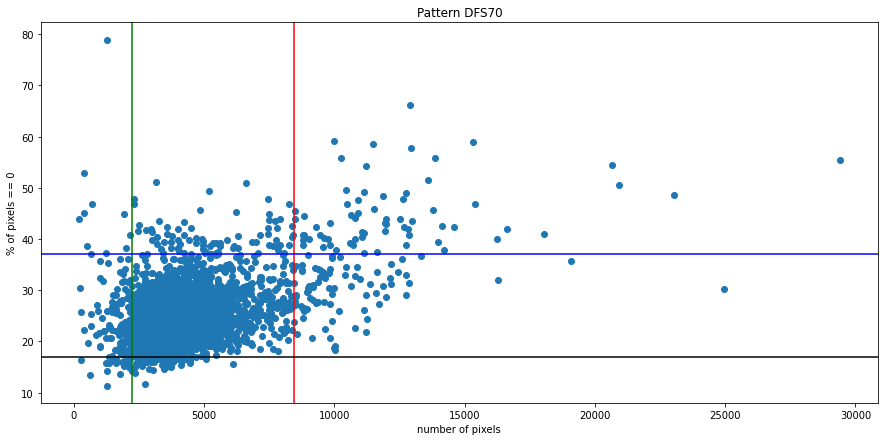

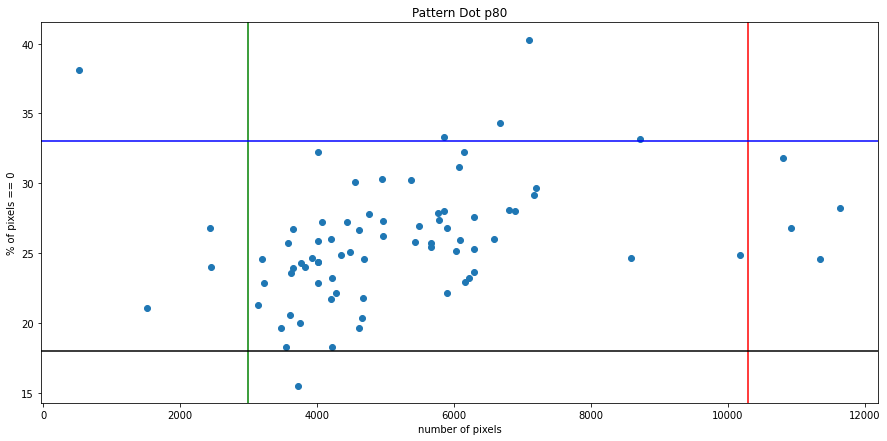

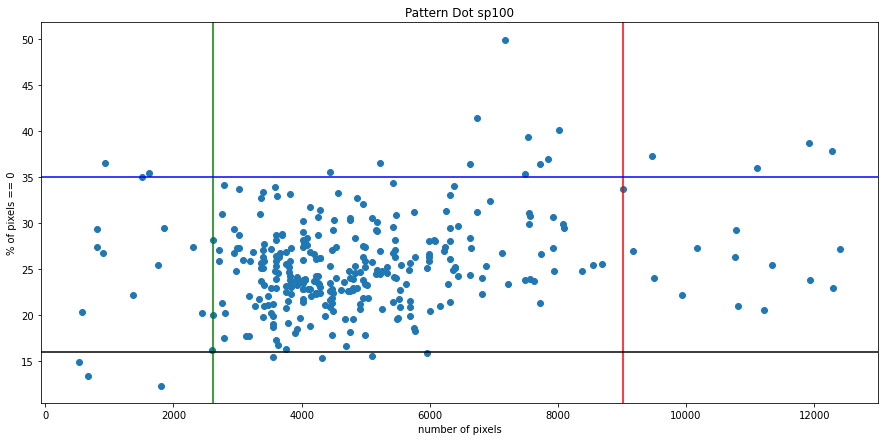

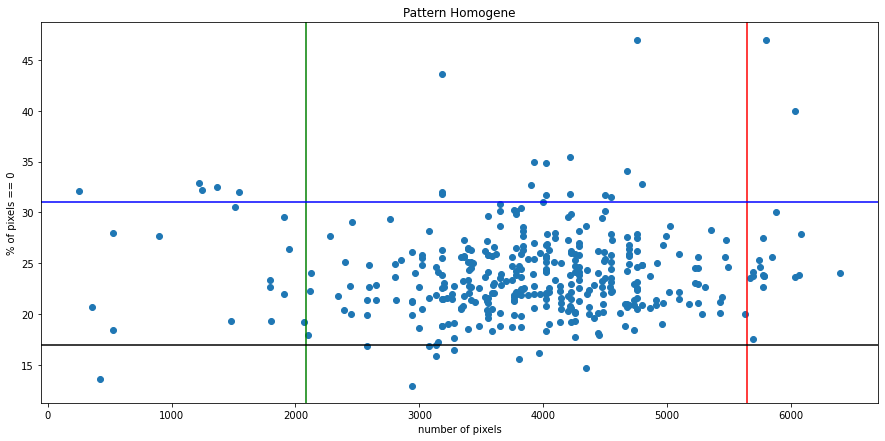

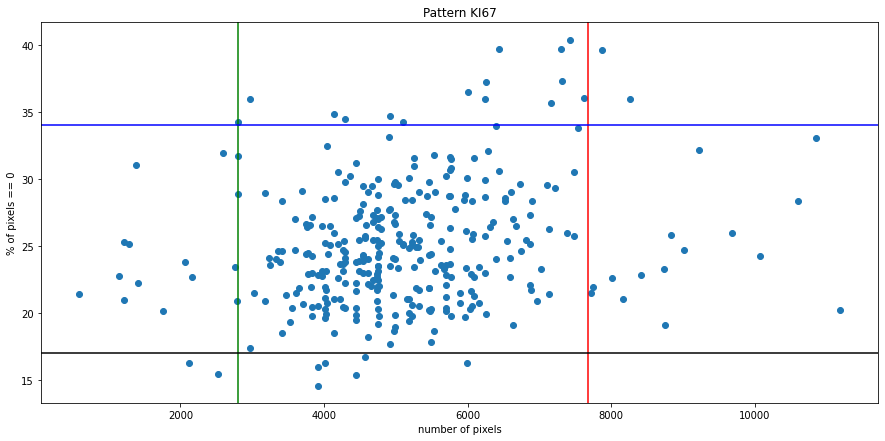

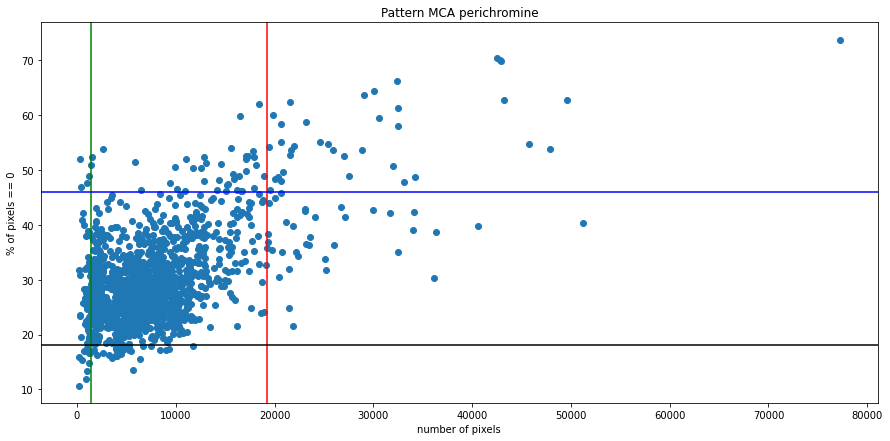

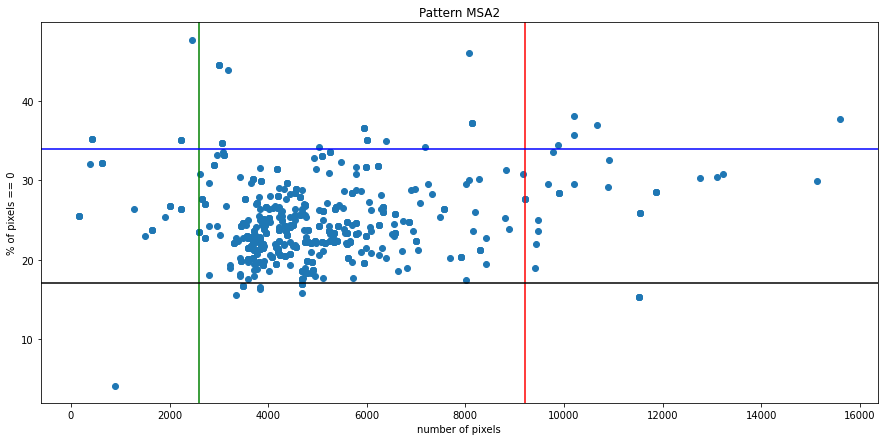

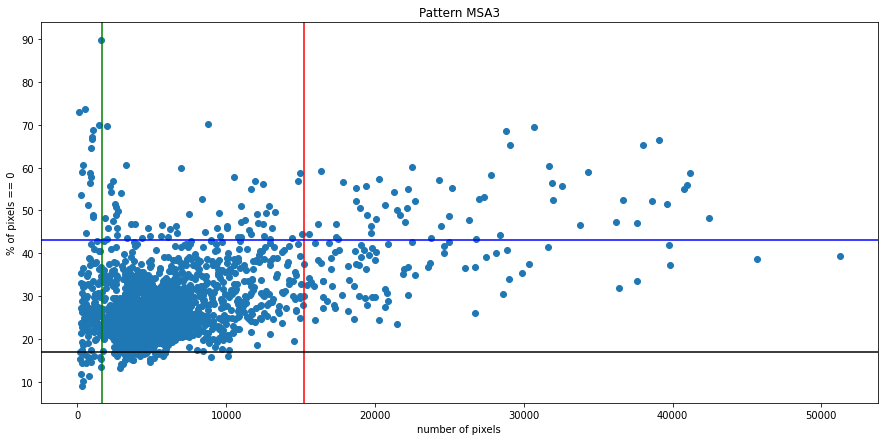

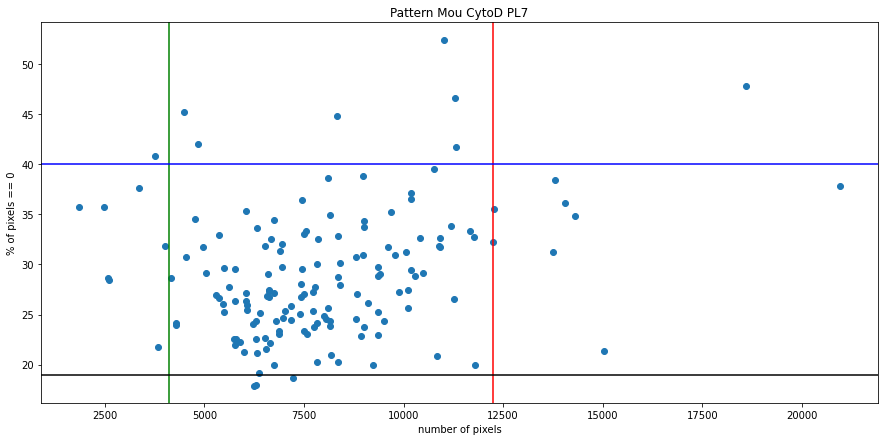

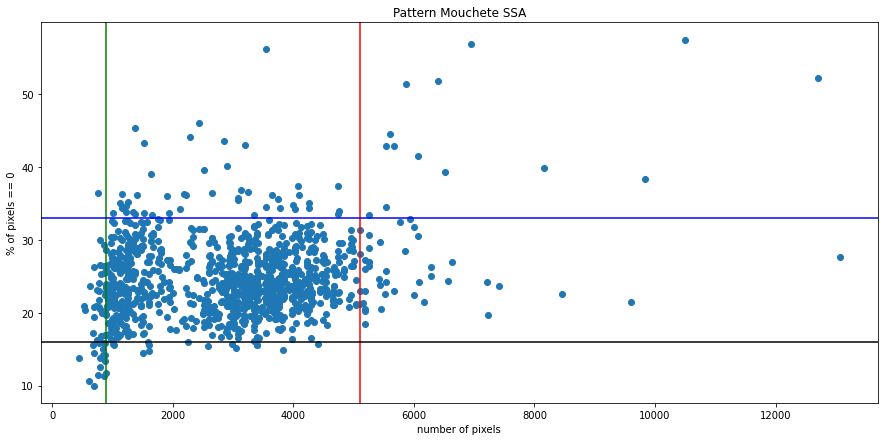

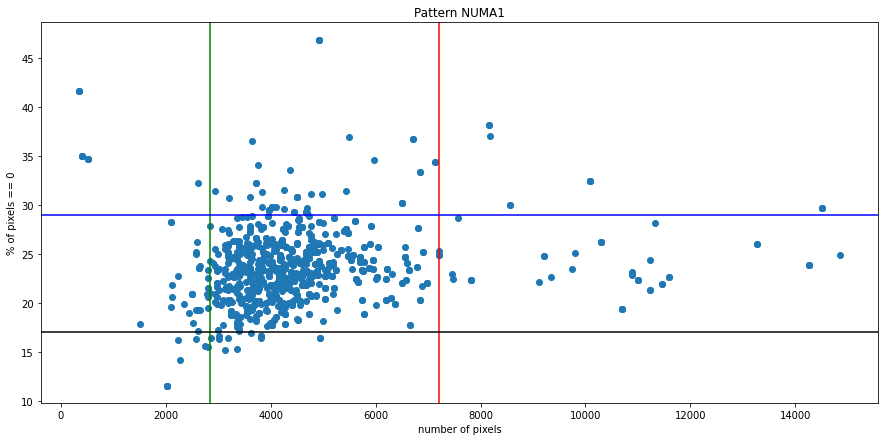

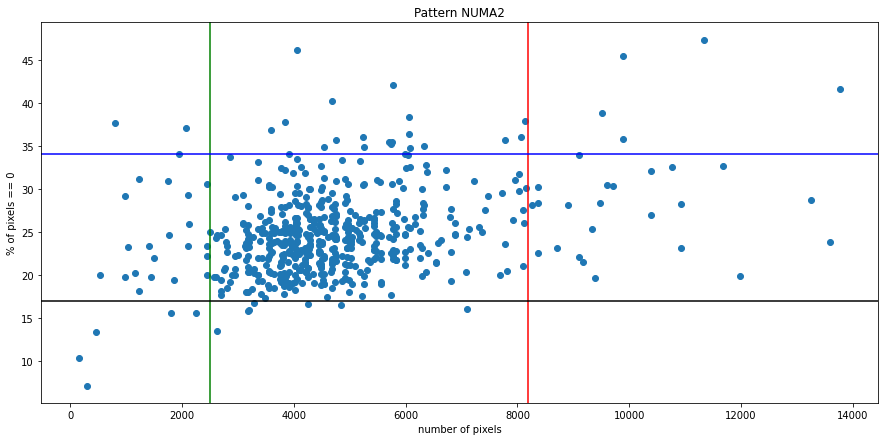

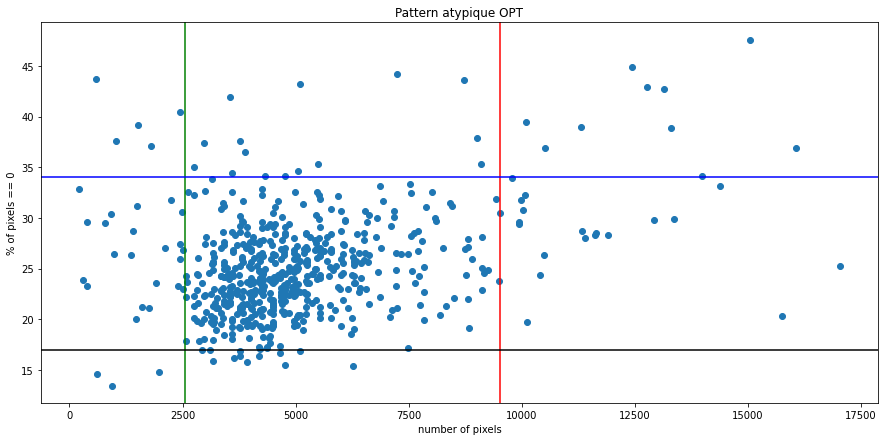

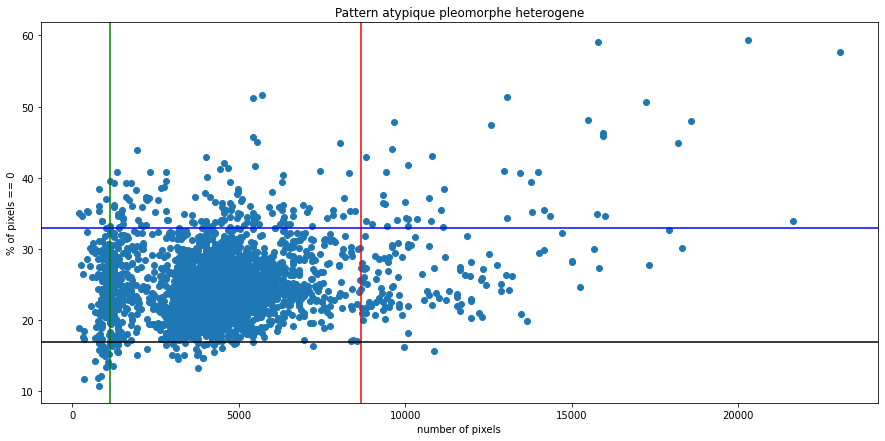

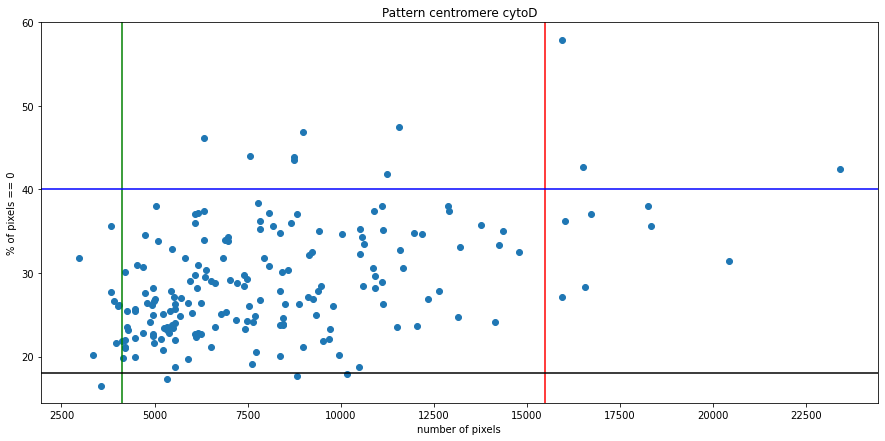

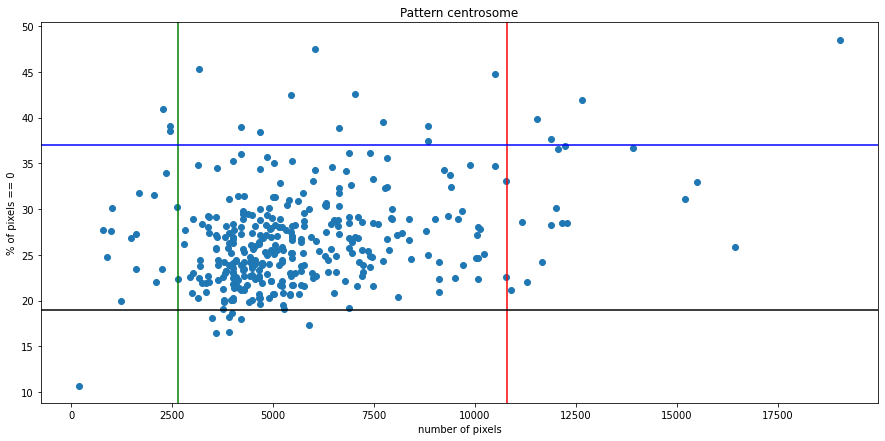

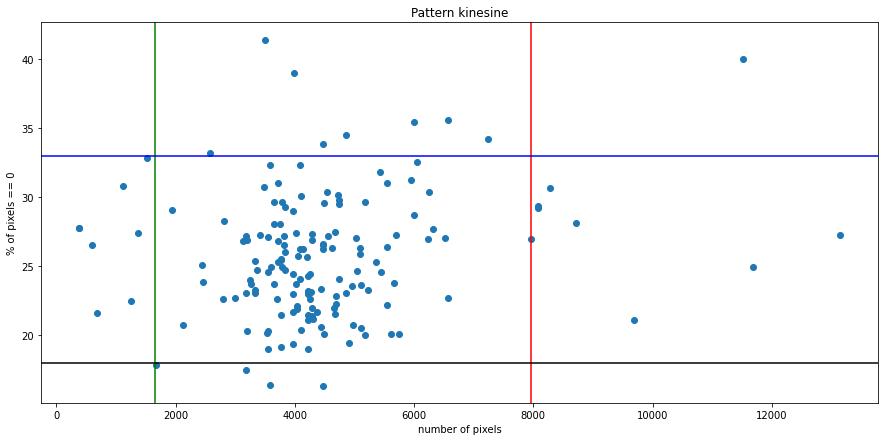

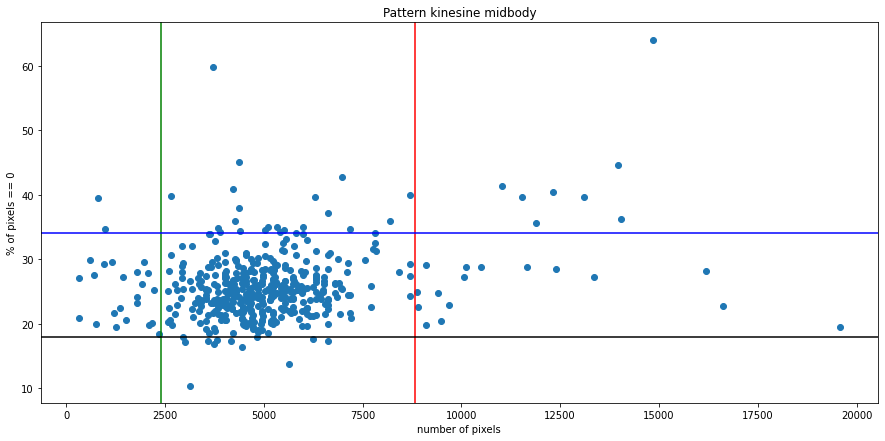

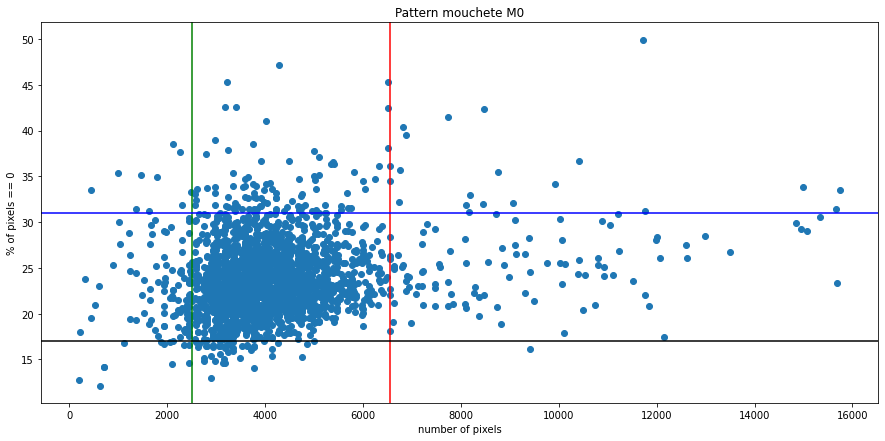

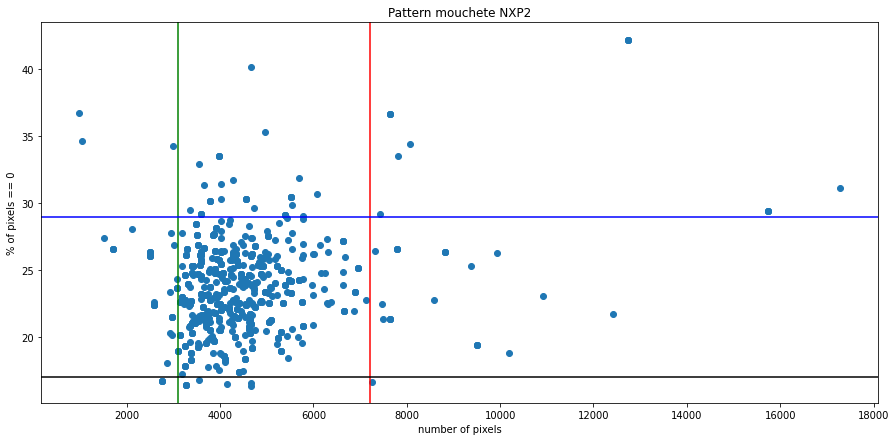

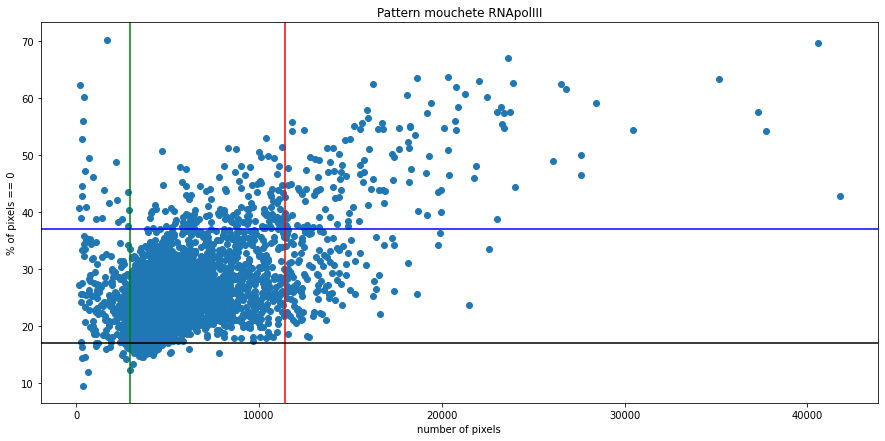

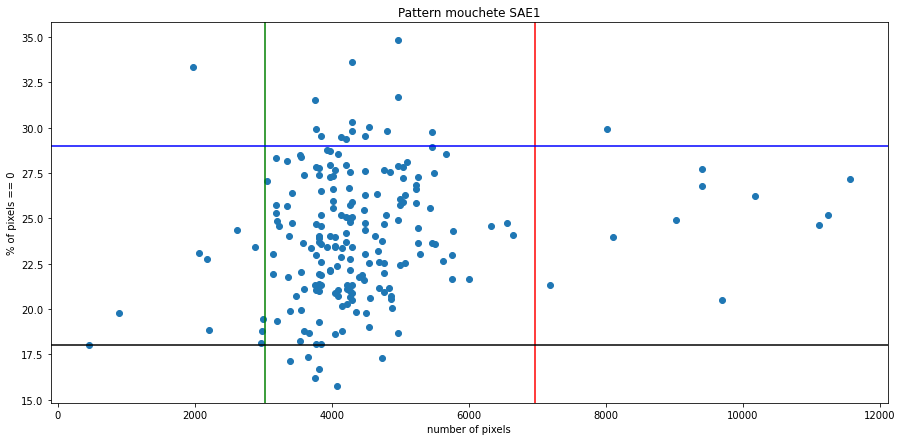

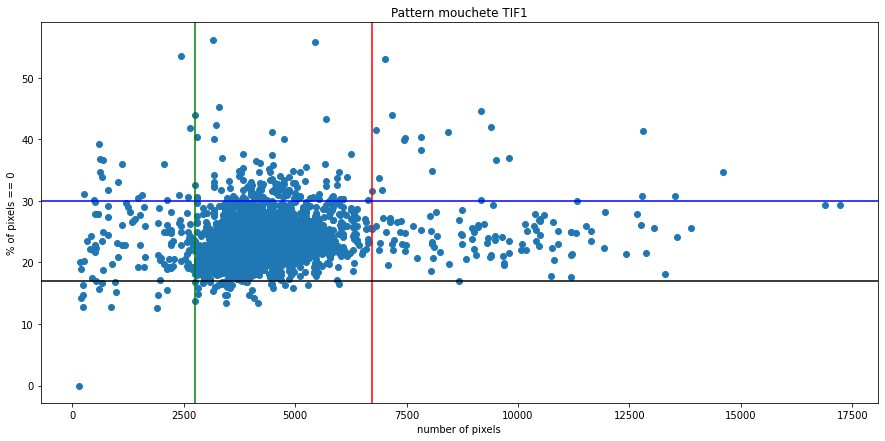

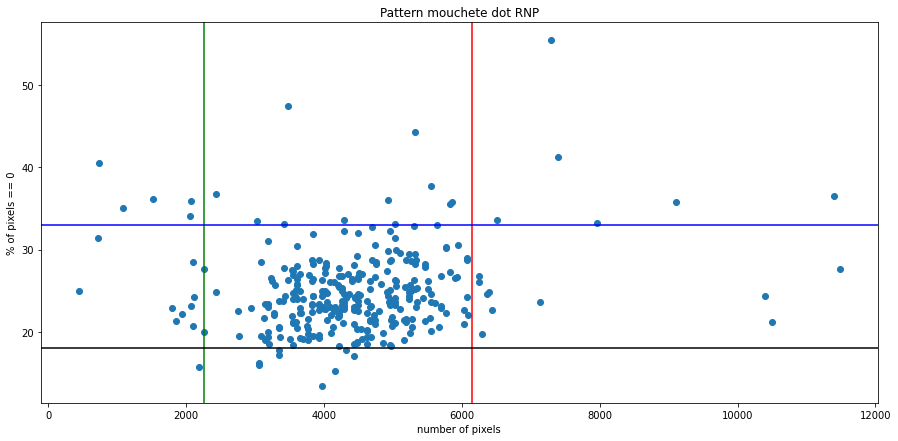

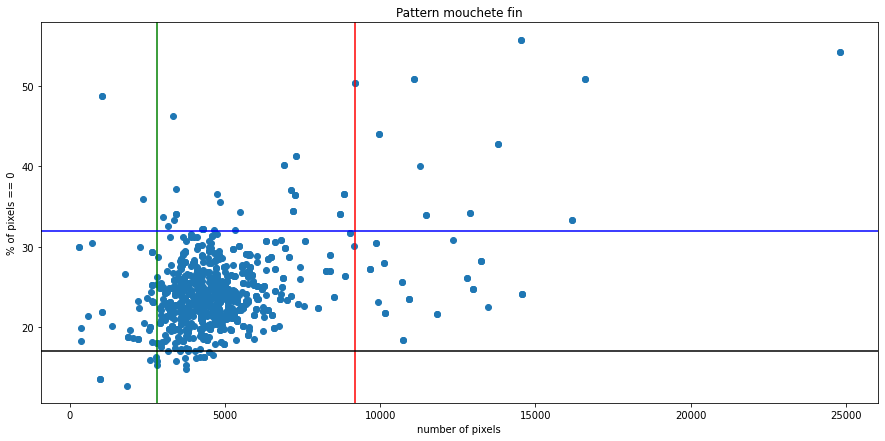

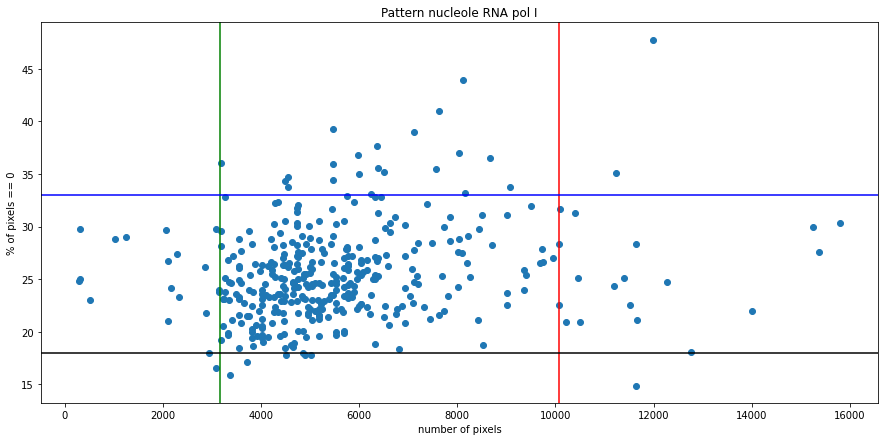

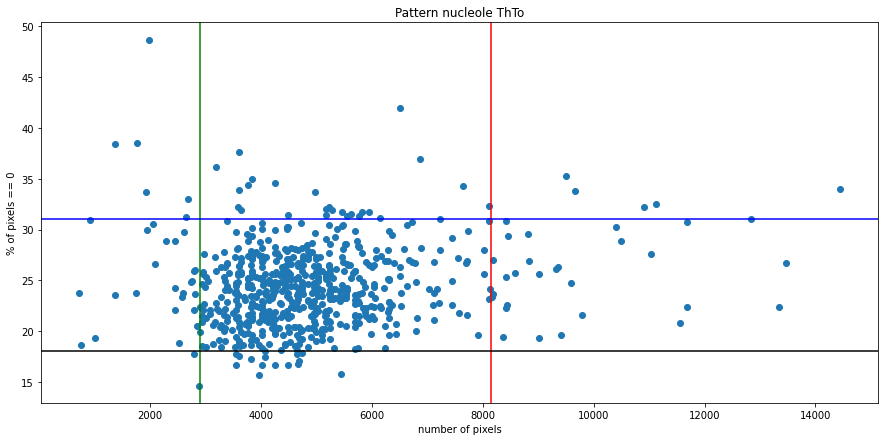

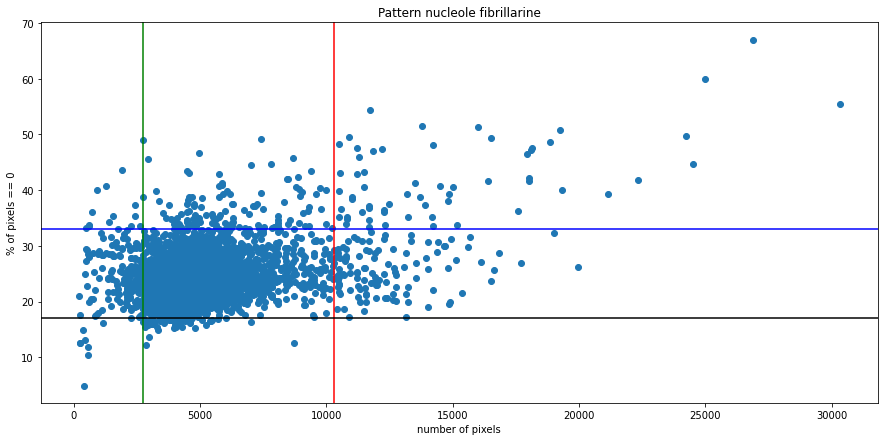

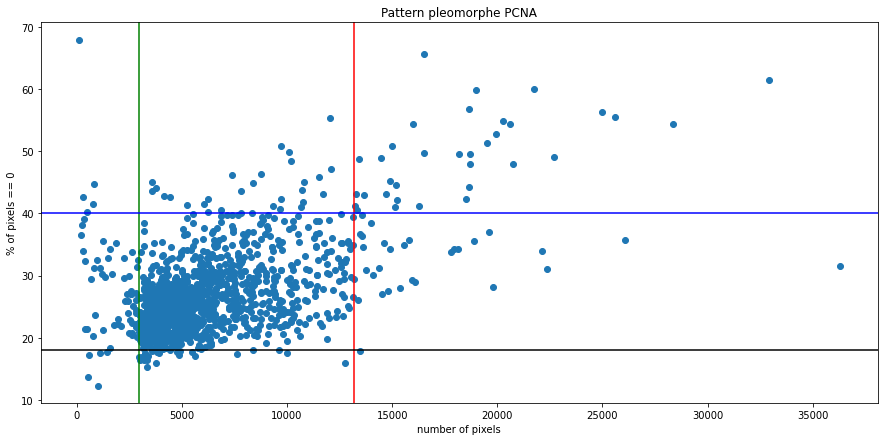

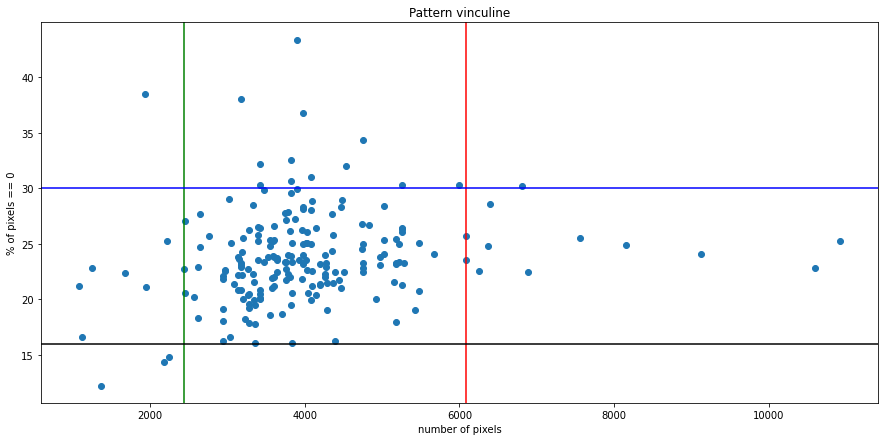

In [ ]:
plot_cell_limiters(X, y, n_classes, y_pattern_dict, pixel_count_parameters, percentage_parameters)

## Plot of average nucleus size


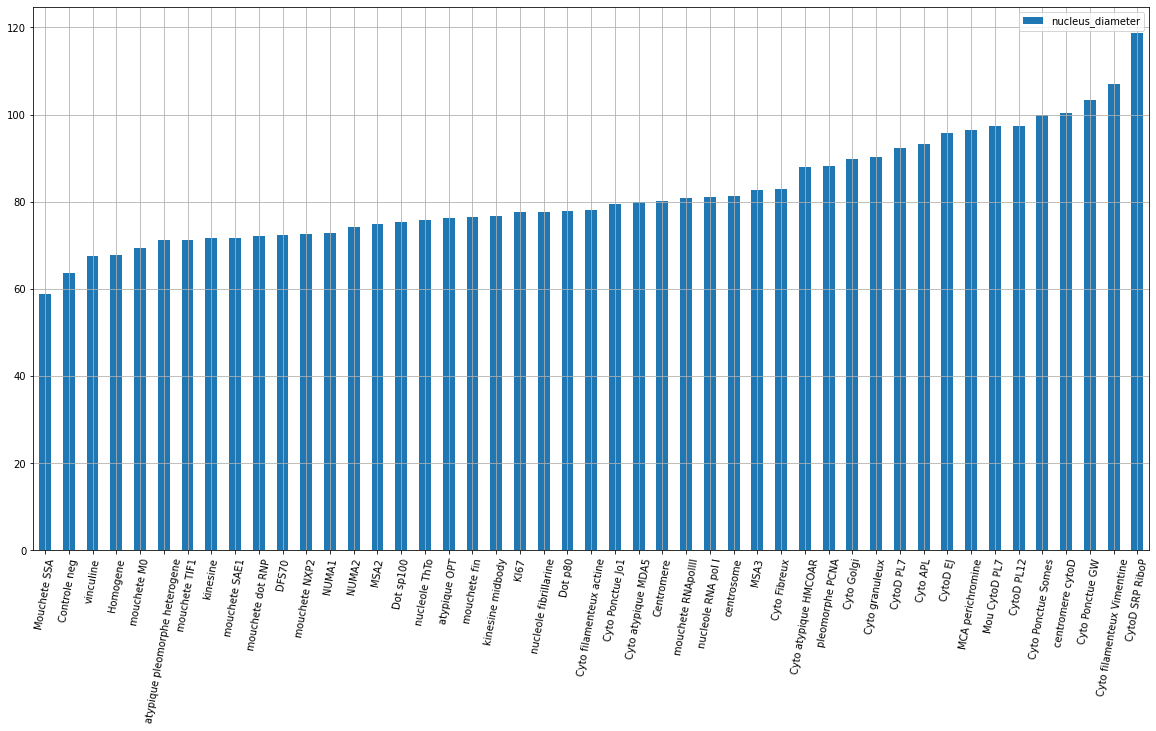

In [ ]:
mean_cell = [(mean_nucleus_diameter[idx],y_pattern_dict[idx]) for idx in np.argsort(mean_nucleus_diameter)]
names = [(y_pattern_dict[idx]) for idx in np.argsort(mean_nucleus_diameter)]
mean = pd.DataFrame(mean_cell, index=names, columns=['nucleus_diameter', 'name'])
ax = mean.plot.bar(figsize=(20,10))
plt.xticks(rotation=80)
plt.grid(True)
plt.show()
mean.to_csv("/content/drive/MyDrive/Dicts/Avarage_Nucleus.csv")

In [ ]:
X_filtered, y_filtered = filter_db(X, y, pixel_count_parameters, percentage_parameters)
square = transform_square(X_filtered)
image_reshape_size = 80
res_square = resize_square(square, image_reshape_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
len(X_filtered)

50098

In [7]:
def cells_plot(X, y, ctype, image_shape, collumn_size):
  """
  Returns a cell mozaic of the pattern given
  """
  n_classes = len(y_pattern_dict)
  count = 0
  limit = collumn_size*(image_shape+2)
  out = np.zeros((2,limit))
  row = np.array([])
  n = 0
  for i, x in enumerate(X):
    c = np.argmax(y[i])
    if c == ctype:
      if count == 0:
        row = np.c_[x, np.zeros((image_shape,2))]
      else:
        row = np.c_[row, np.c_[x, np.zeros((image_shape,2))]]
      count += 1
      if count == collumn_size:
        n += collumn_size
        out = np.r_[out, np.zeros((2,limit))]
        out = np.r_[out, row]
        row = np.array([])
        count = 0
        if n>99:
          break
  n += count
  if count != 0:
    for i in range(count, collumn_size):
        row = np.c_[row, np.c_[np.zeros((image_shape,image_shape+2))]]
    out = np.r_[out, np.zeros((2,limit))]
    out = np.r_[out, row]
  w, h = out.shape
  output = np.zeros((w, h, 3))
  output[:,:,1] = out
  return output, n
  

## Results:

As we can see the contrast normalization added on the images before putting them through Cellpose creates cells that are better segmentated, but adds more noise to our data.

In [ ]:
for i in range(len(y_pattern_dict)):
  mozaic , n = cells_plot(res_square, y_filtered, i, image_reshape_size, 10)
  affiche(mozaic,titre=f'Pattern {y_pattern_dict[i]} - Number of cells: {n}')

Output hidden; open in https://colab.research.google.com to view.

# Patterns

In [9]:
pattern_folder = "/content/drive/MyDrive/Images/Cells/Pattern cells"
print('Importing...')

# y_pattern_dict is a vector that translates the position of the one-hot-encoder array to the pattern number observed in the folders
        # Example:
        # if 25 is at position 0, it means that an image with an output of [1 0 0...] is classified as being from pattern 25
n_classes = len(sorted(glob.glob(pattern_folder + '/*')))
y_pattern_dict = ["" for i in range(n_classes)]

X = np.array([]) #dataset
y = []
n_divs = 10

hist_pixel_count = [[] for i in range(n_classes)] #matrix with cell pixel count per pattern
hist_largest_dimension = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern
hist_percentage = [[] for i in range(n_classes)]#matrix with cell max dimension per pattern

i = 0
for pattern_number_path in sorted(glob.glob(pattern_folder + '/*')): #iterating in every pattern
  pattern_number = pattern_number_path[len(pattern_folder)+1:] #Number of pattern
  y_pattern_dict[i] = pattern_number 
  print(pattern_number)
  for np_cells in sorted(glob.glob(pattern_number_path + '/*')):#iterating for every numpy array
    a = np.load(np_cells, allow_pickle=True) #gets array from drive
    # One hot encoder
    auxy = np.zeros(n_classes)
    auxy[i] = 1
    for j in range(len(a)):
      y.append(auxy)
    X = np.append(X, a)
    #histogram construction and segregation into best images
    for img in a:
      # segregation by percentage
      numzeros = (img == 0).sum()
      numnot = (img != 0).sum()
      div = min(((numnot*100/(numnot+numzeros))//10), n_divs-1)
      
      # segregation by area size
      size = img.shape[0]*img.shape[1]
      div = min(size//250, n_divs-1)

      # histograms 
      size = img.shape[0]*img.shape[1]
      hist_pixel_count[i].append(size)
      hist_largest_dimension[i].append(max(img.shape[0], img.shape[1]))
      hist_percentage[i].append(100*np.count_nonzero(img==0)/size)

  i += 1
hist_largest_dimension = np.asarray(hist_largest_dimension)
mean_nucleus_diameter = [np.mean(nuc) for nuc in hist_largest_dimension]

y = np.array(y)


Importing...
pat_10
pat_11
pat_12
pat_13
pat_15
pat_16
pat_18
pat_19
pat_22
pat_23
pat_25
pat_7
pat_8
pat_9


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
def size_hist(hist, n_classes, y_pattern_dict, percent=False):
  plt.subplots(n_classes//2+n_classes%2, 2, figsize=(15, 40))
  critical_out = []
  for i in range(n_classes):
    plt.subplot(n_classes//2+n_classes%2, 2, i+1)
    plt.hist(hist[i], 80)
    critical1 = np.quantile(hist[i], 0.95)
    plt.axvline(critical1, color='g', label=f'Critical:{int(critical1)}')
    if percent:
      critical2 = np.quantile(hist[i], 0.03)
    else:
      critical2 = np.quantile(hist[i], 0.05)
    plt.axvline(critical2, color='r', label=f'Critical:{int(critical2)}')
    plt.title(f'Pattern: {y_pattern_dict[i]}')
    plt.legend()
    critical_out.append((int(critical1), int(critical2)))
  plt.tight_layout()
  plt.show()
  return critical_out

### Plot histograms of pixels

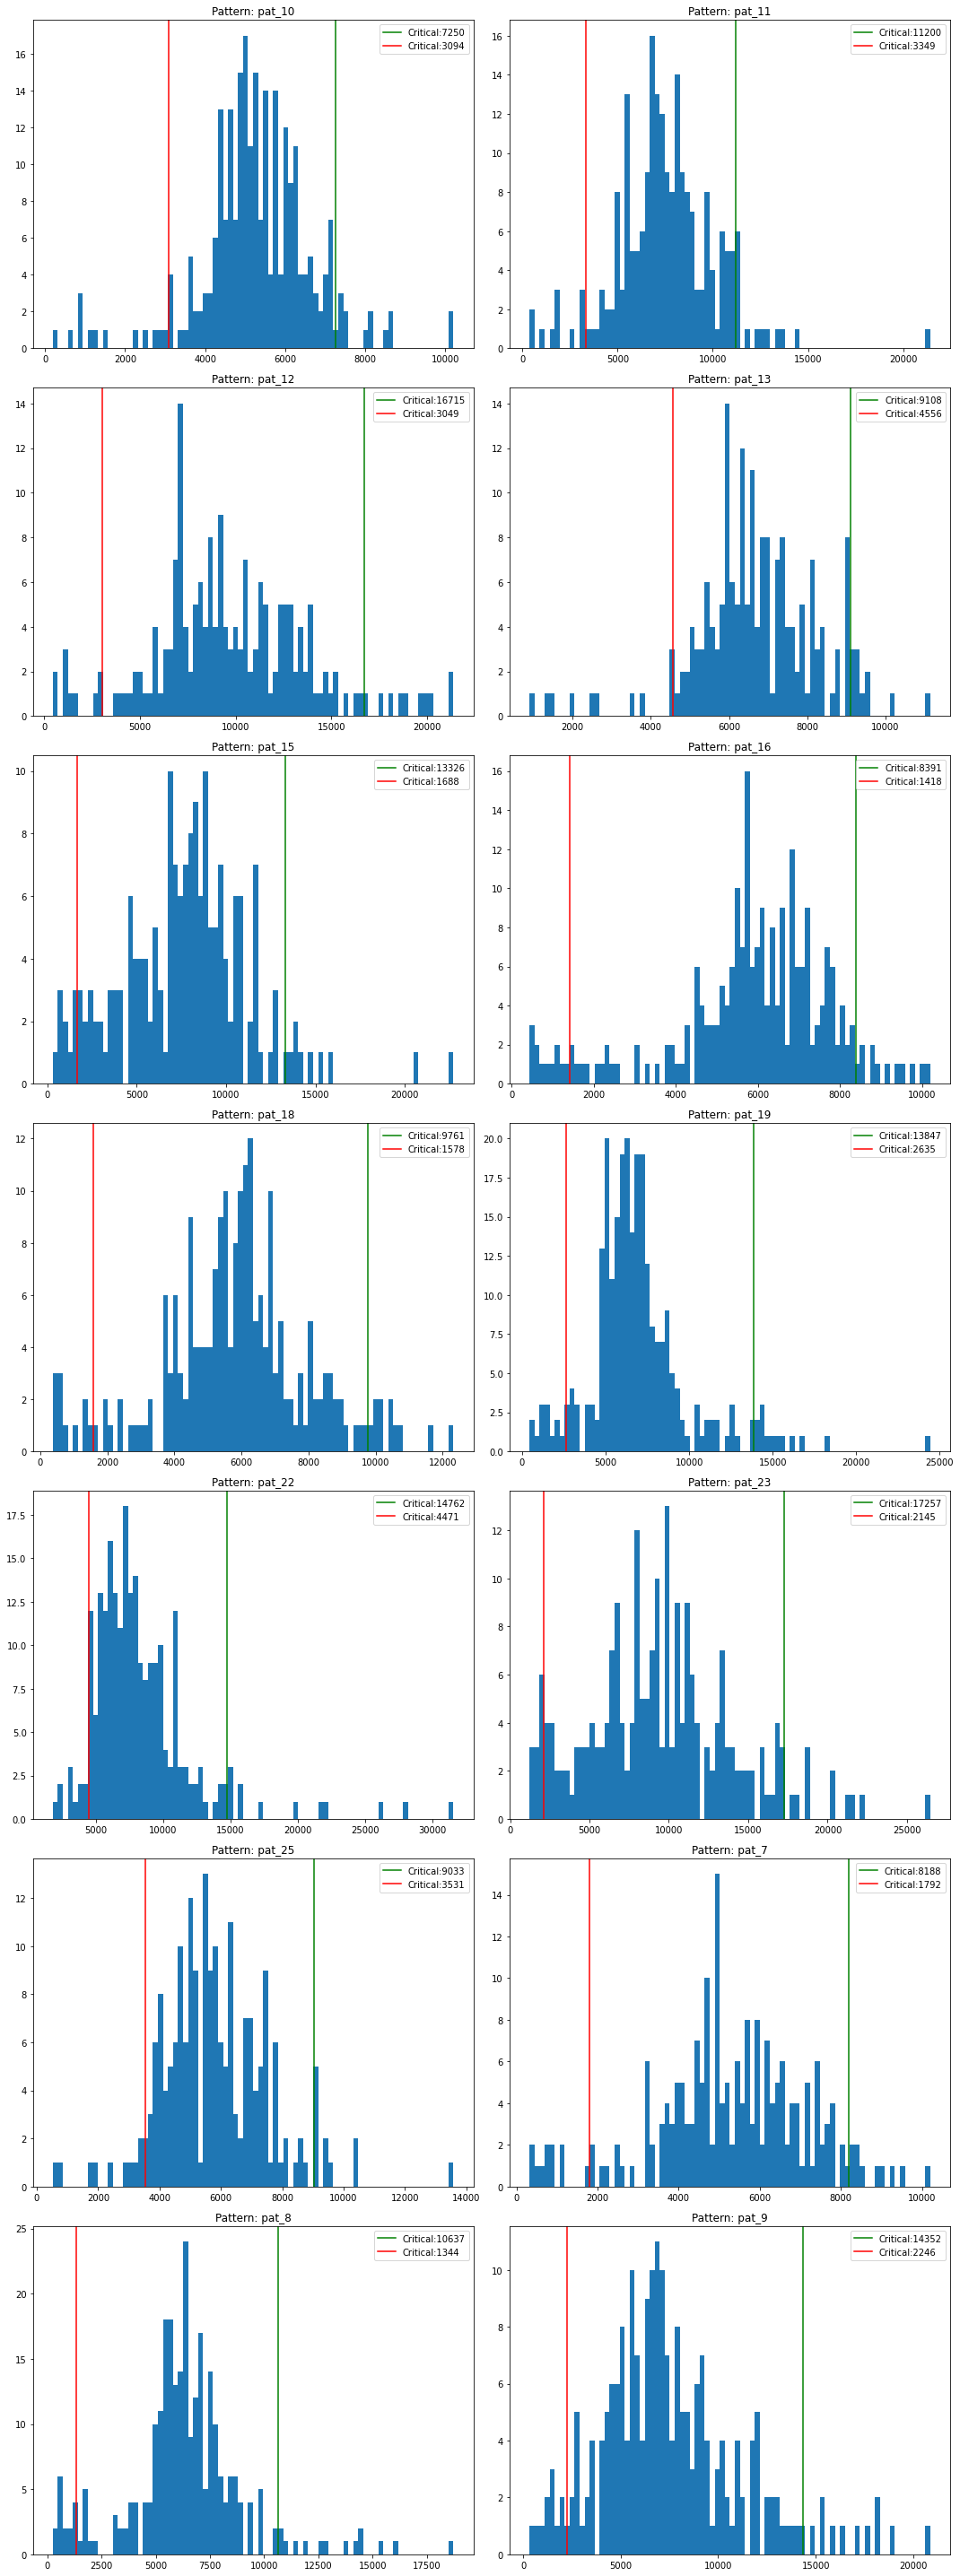

In [11]:
pixel_count_parameters = size_hist(hist_pixel_count, n_classes, y_pattern_dict)

### Plot largest dimension histogram

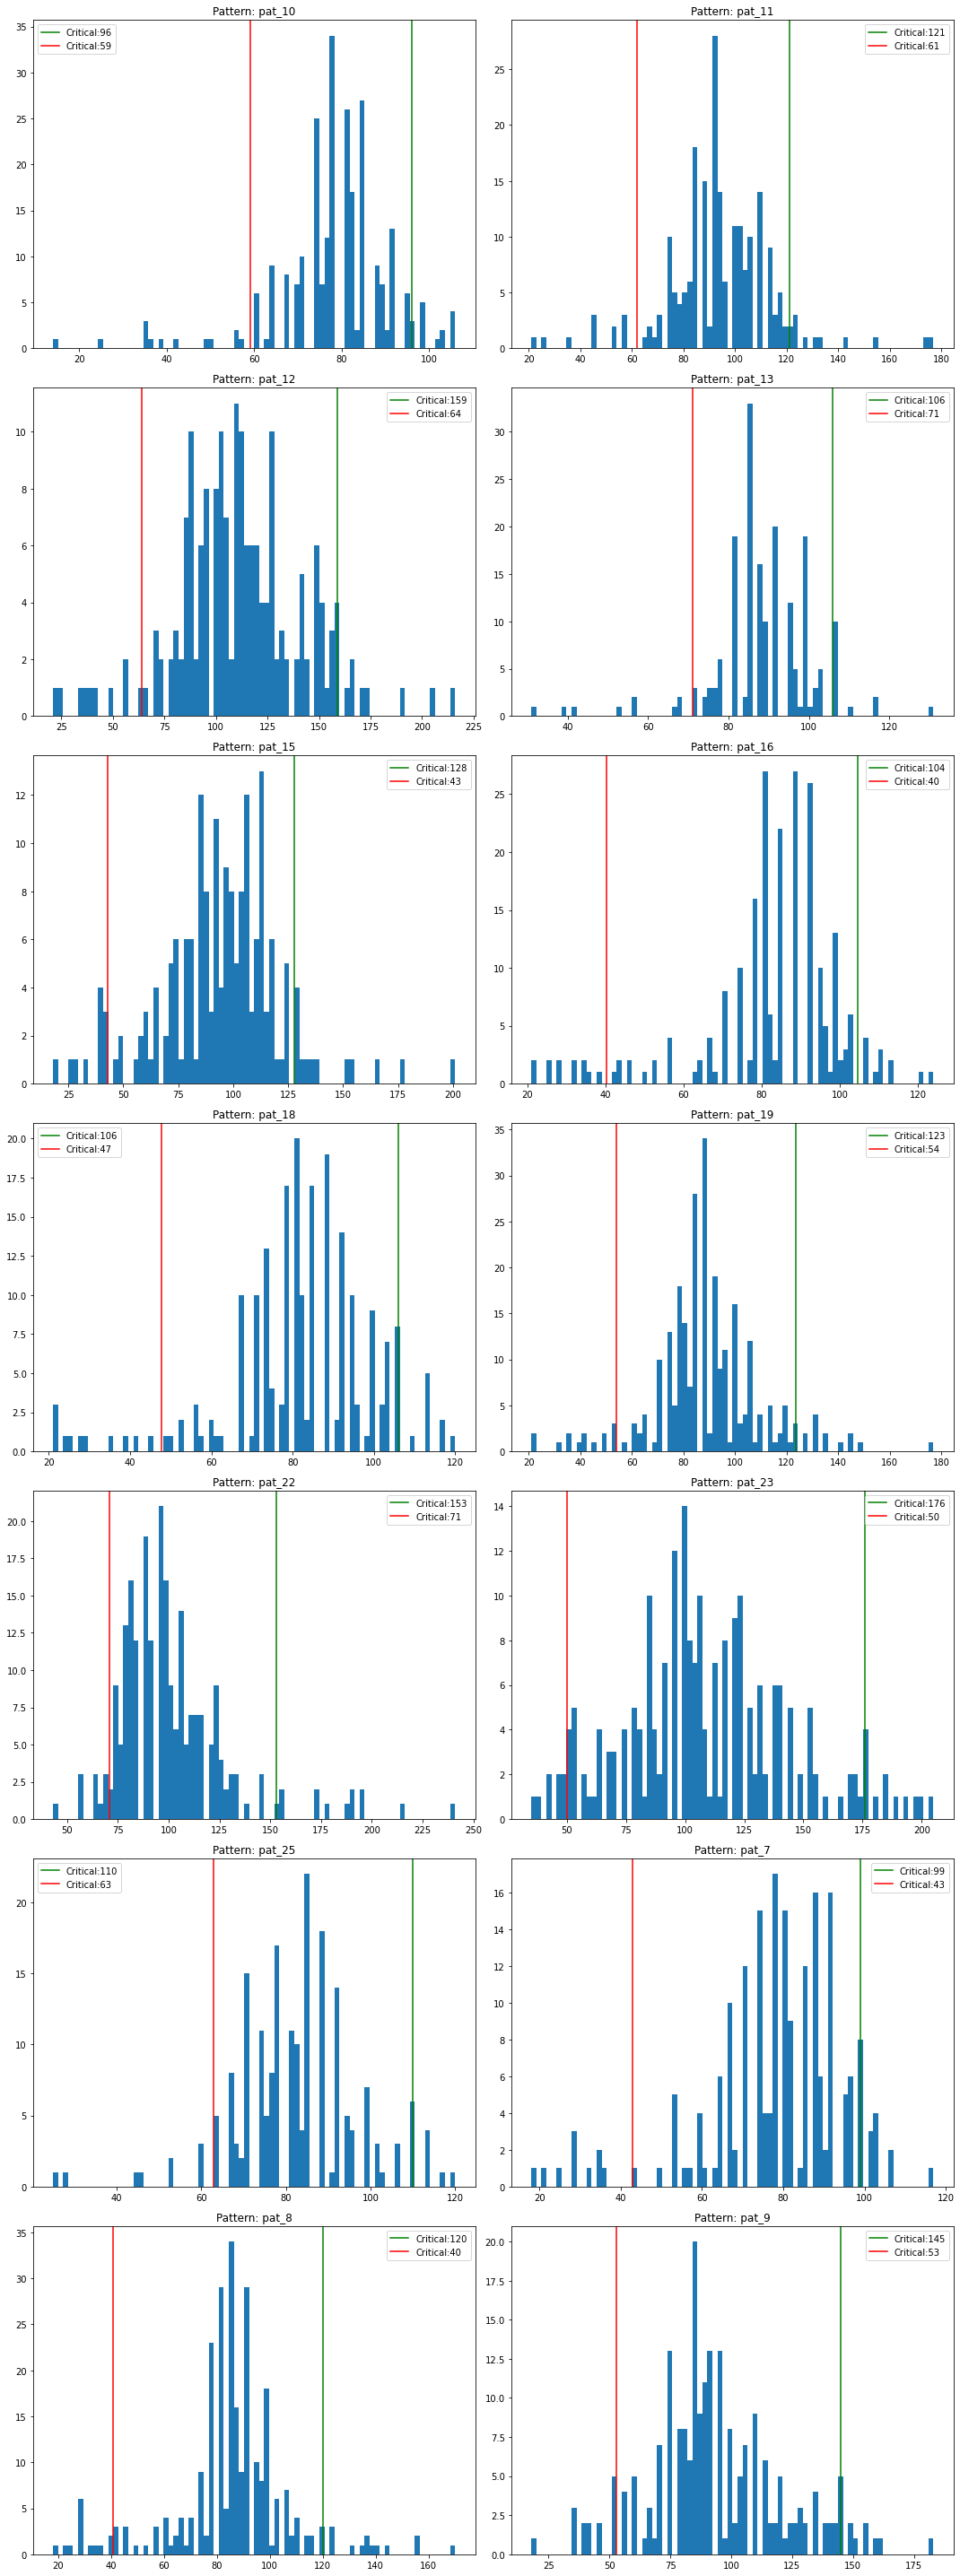

In [12]:
largest_dimension_parameters = size_hist(hist_largest_dimension, n_classes, y_pattern_dict)

## By percentage of black pixels

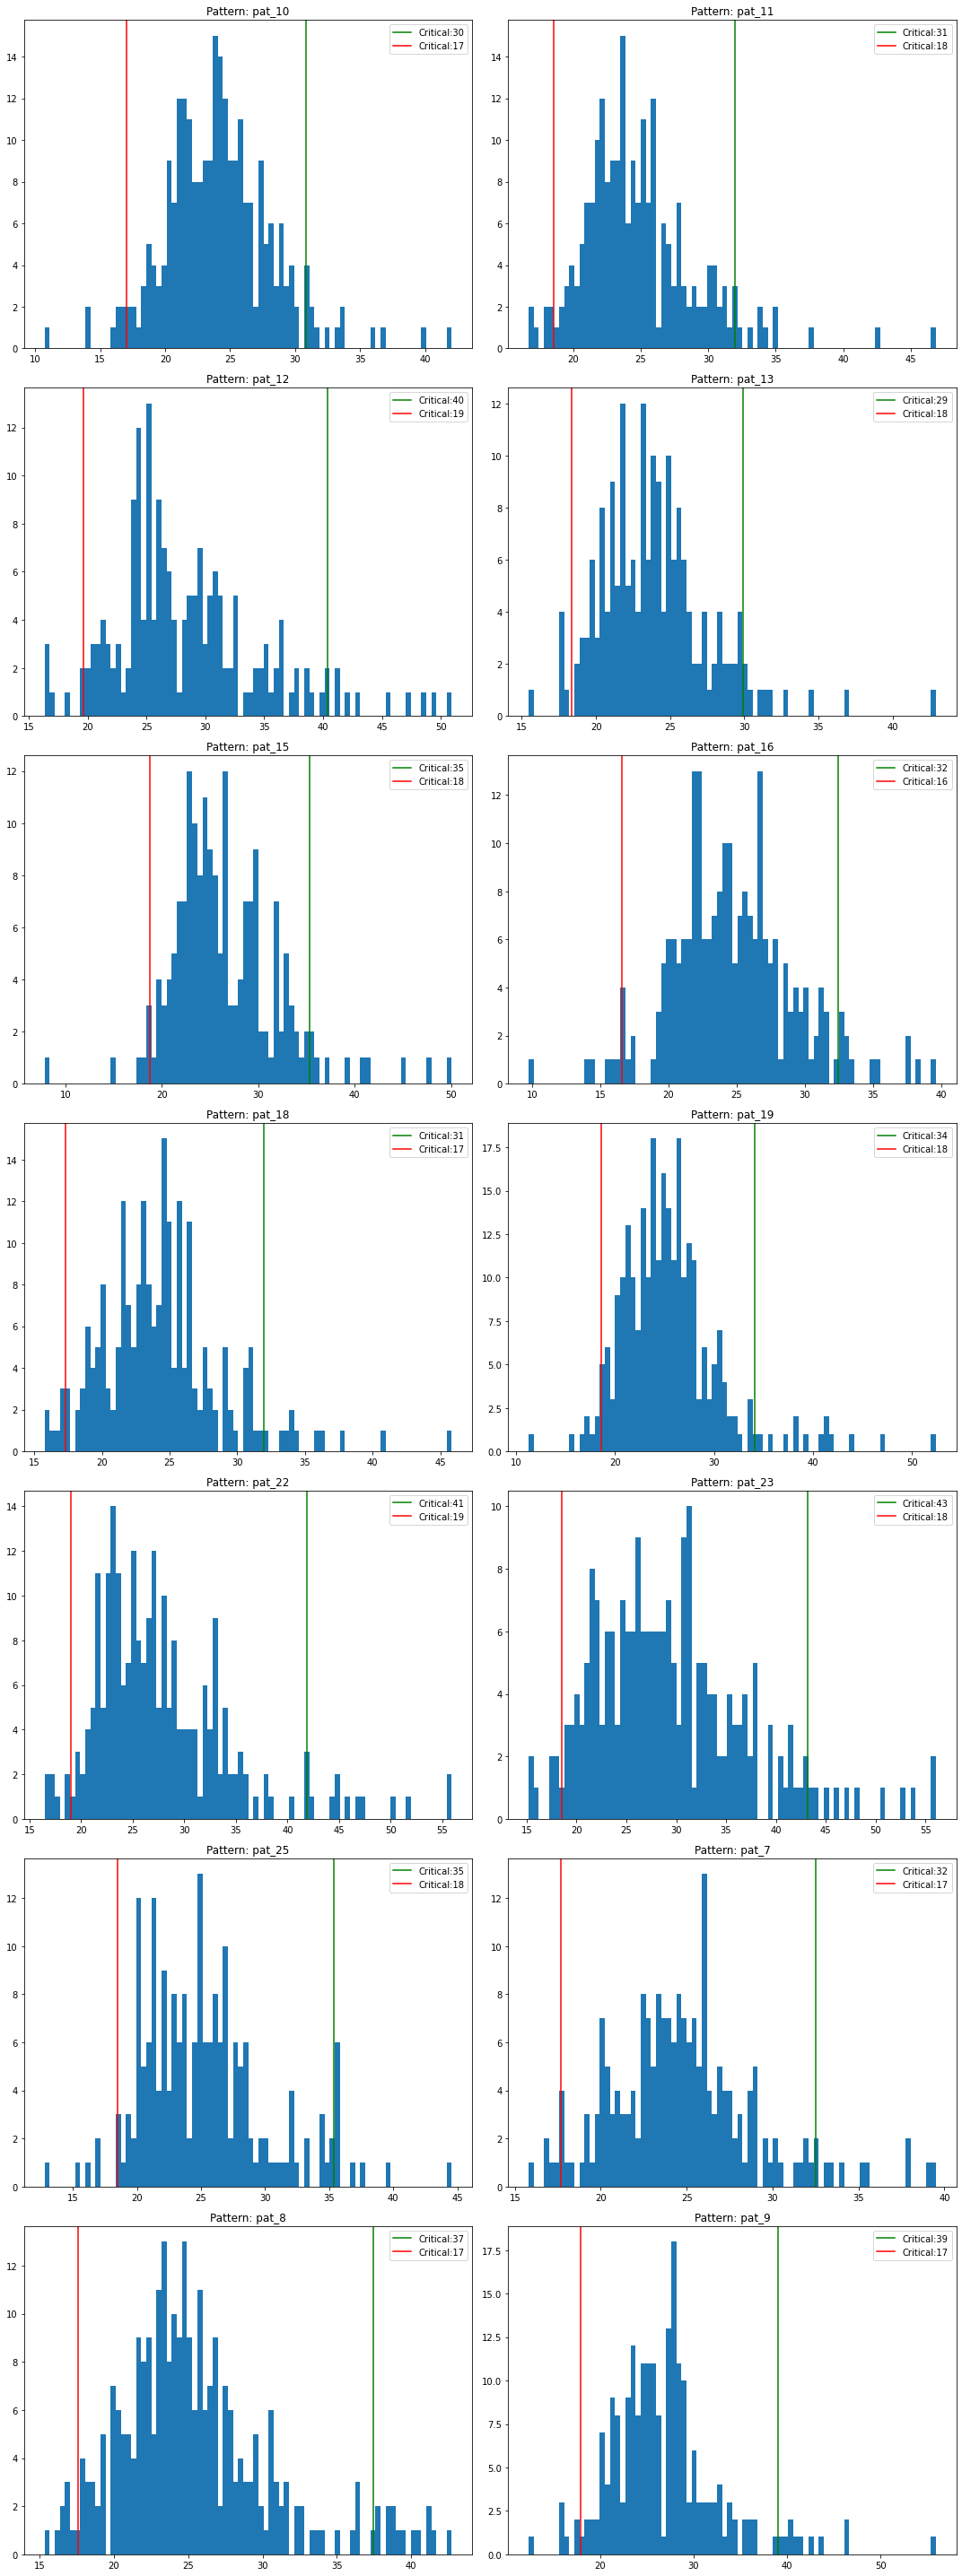

In [13]:
percentage_parameters = size_hist(hist_percentage, n_classes, y_pattern_dict, True)

### Plot filtering by porcentage and size of cells

In [14]:
def plot_cell_limiters(X, y, n_classes, y_pattern_dict, pixel_count, percentage):
  n_pixels = []
  emptyspace = []
  for i in range(n_classes):
    n_pixels.append([])
    emptyspace.append([])

  for i in range(len(X)):
    iclass = np.argmax(y[i])
    n = X[i].shape[0]*X[i].shape[1]
    n_pixels[iclass].append(n)
    emptyspace[iclass].append(100*np.count_nonzero(X[i]==0)/n)

  for i in range(n_classes):
    plt.figure(figsize=(15, 7))
    plt.title(f'Pattern {y_pattern_dict[i]}')
    plt.xlabel("number of pixels")
    plt.ylabel("% of pixels == 0")
    plt.axvline(pixel_count[i][0], color='r')
    plt.axvline(pixel_count[i][1], color='g')
    plt.axhline(percentage[i][0], color='b')
    plt.axhline(percentage[i][1], color='black')
    plt.scatter(n_pixels[i], emptyspace[i])
    plt.show()

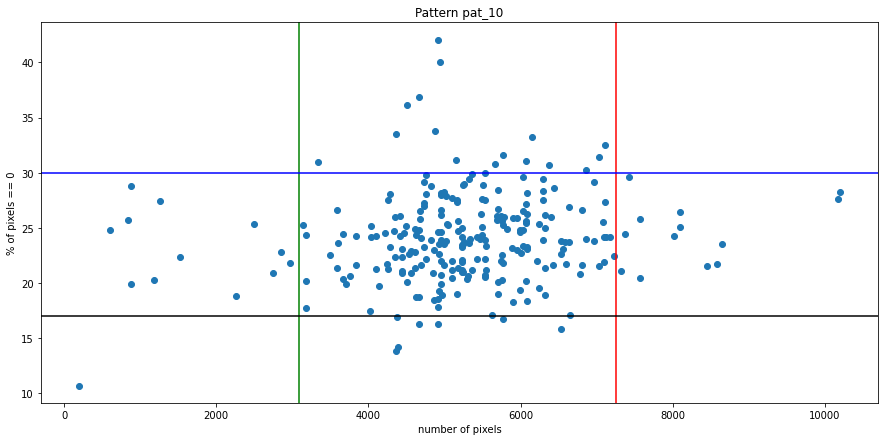

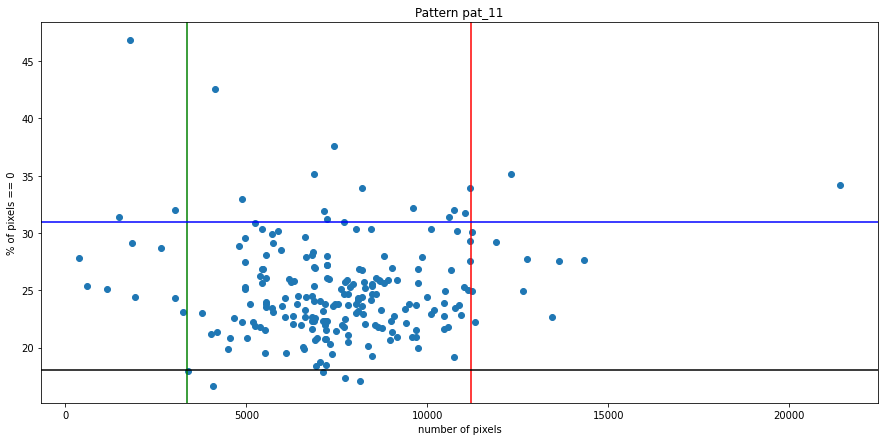

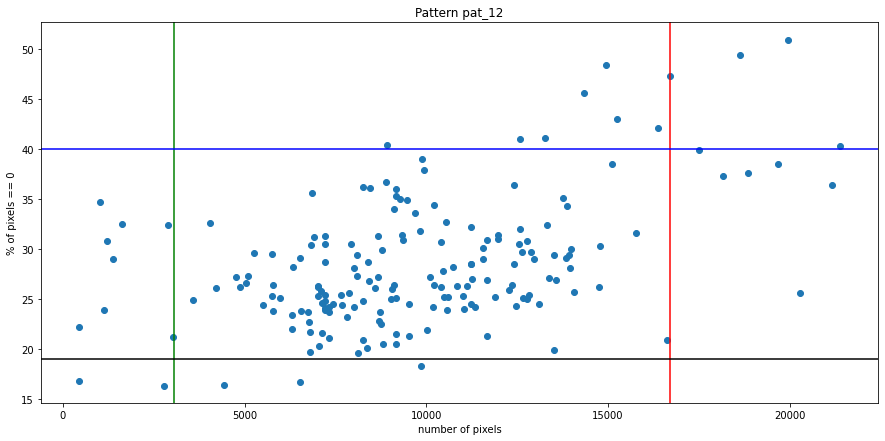

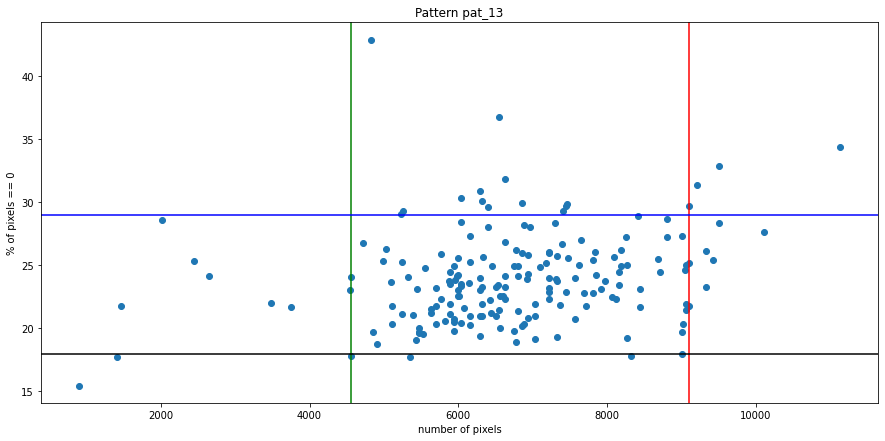

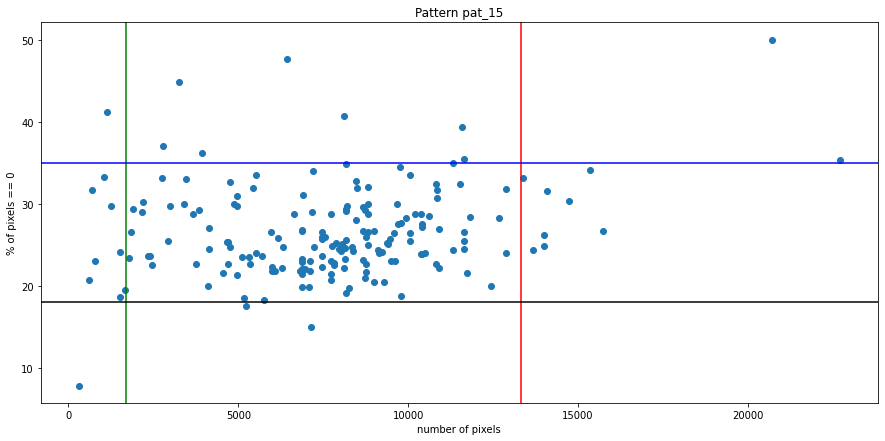

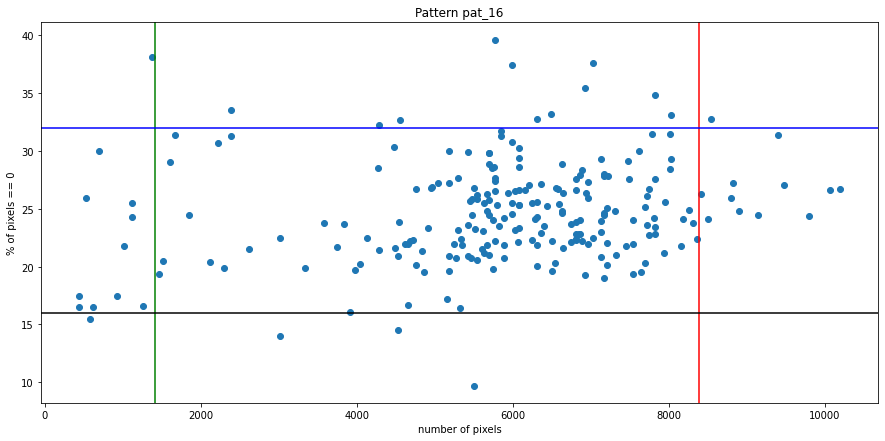

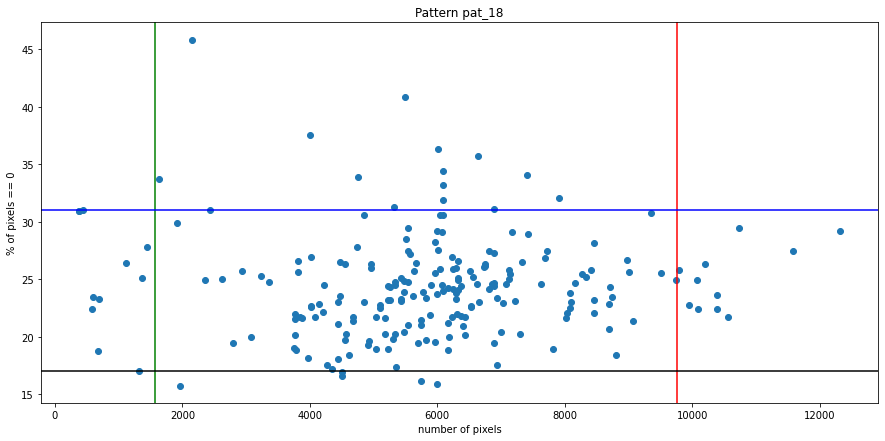

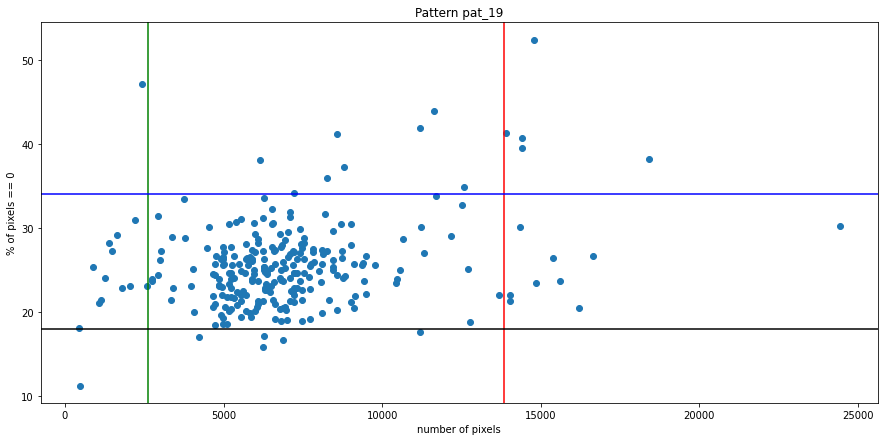

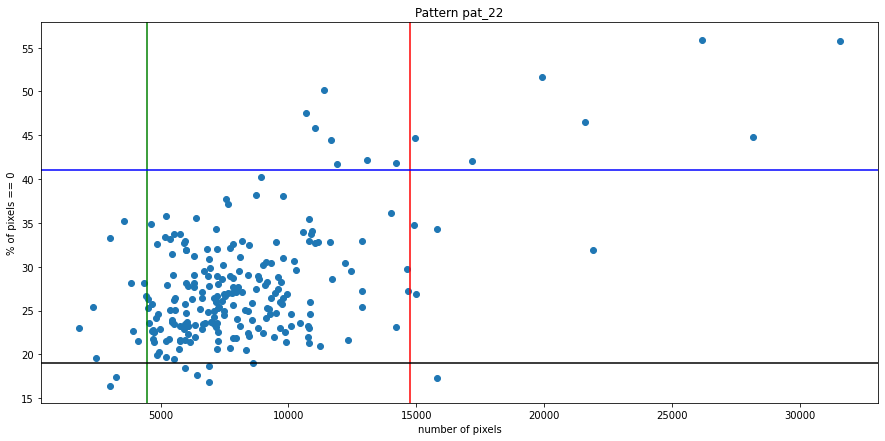

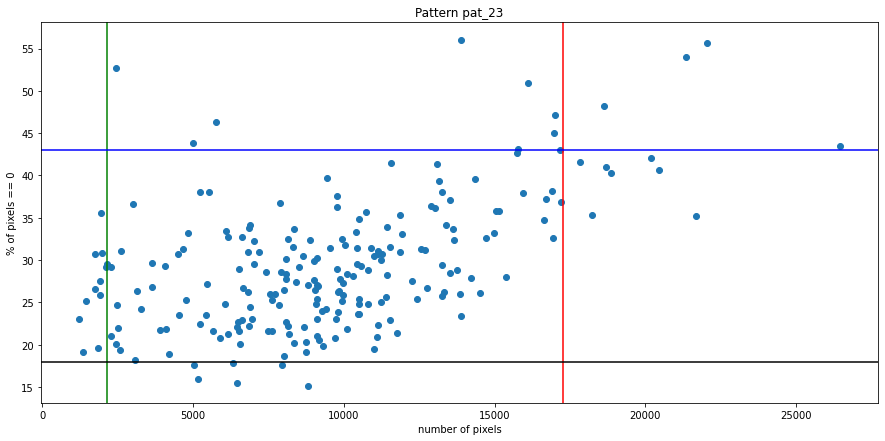

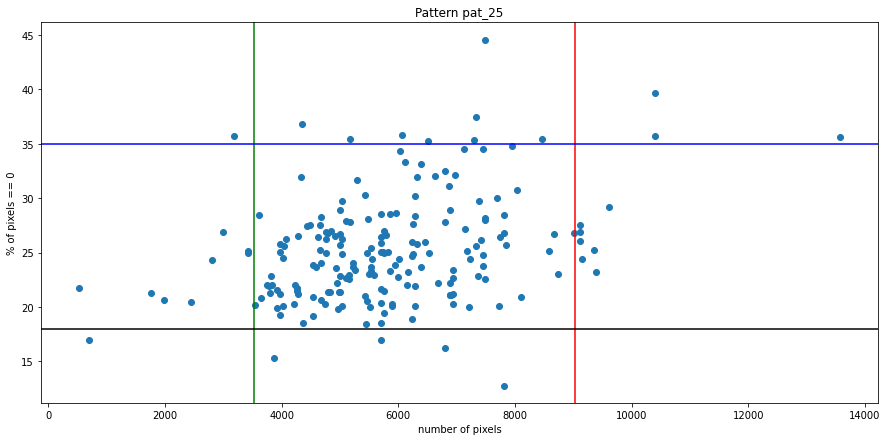

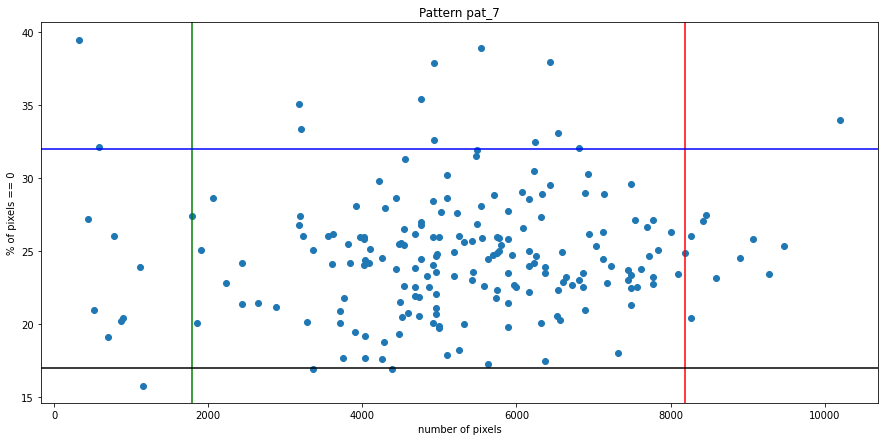

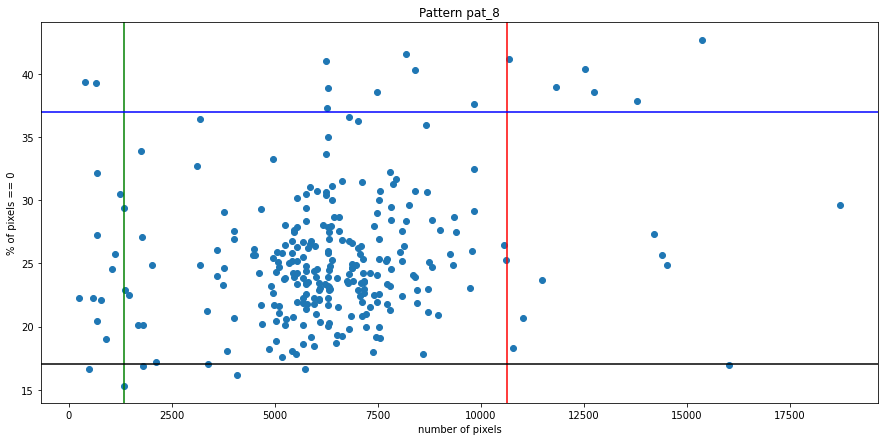

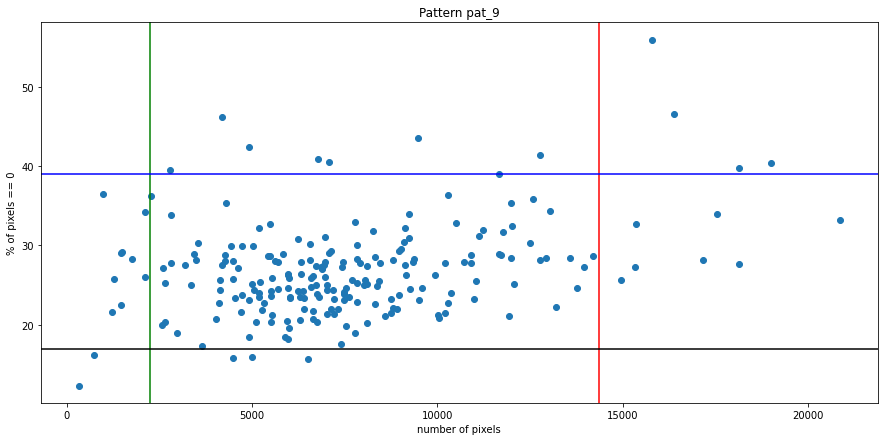

In [15]:
plot_cell_limiters(X, y, n_classes, y_pattern_dict, pixel_count_parameters, percentage_parameters)

## Plot of average nucleus size


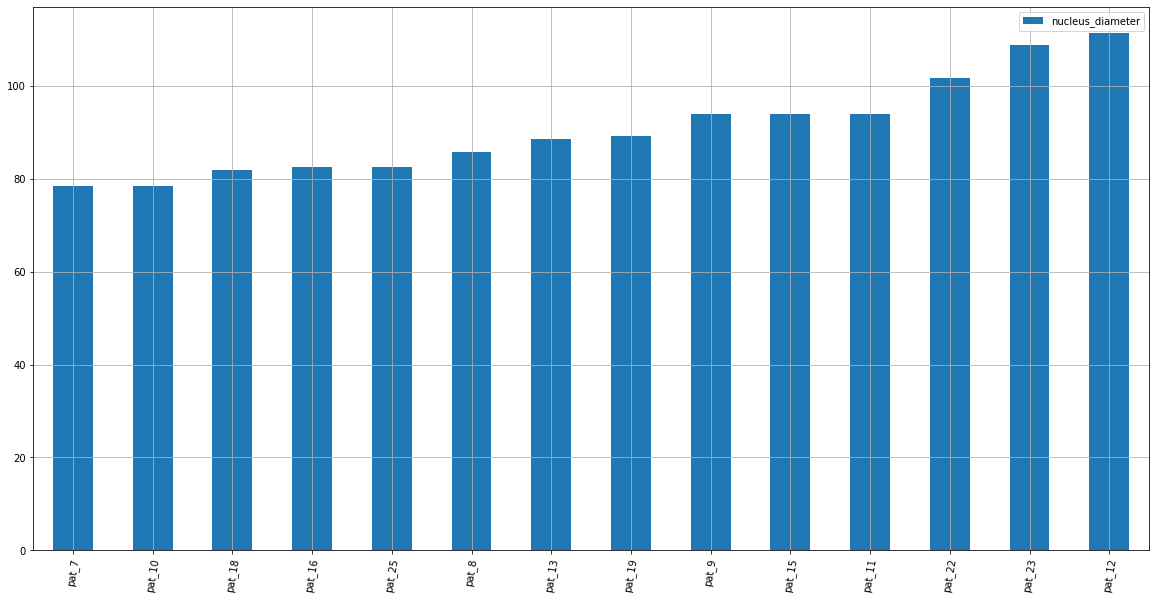

In [16]:
mean_cell = [(mean_nucleus_diameter[idx],y_pattern_dict[idx]) for idx in np.argsort(mean_nucleus_diameter)]
names = [(y_pattern_dict[idx]) for idx in np.argsort(mean_nucleus_diameter)]
mean = pd.DataFrame(mean_cell, index=names, columns=['nucleus_diameter', 'name'])
ax = mean.plot.bar(figsize=(20,10))
plt.xticks(rotation=80)
plt.grid(True)
plt.show()
mean.to_csv("/content/drive/MyDrive/Dicts/Avarage_Pattern_Nucleus.csv")

In [17]:
X_filtered, y_filtered = filter_db(X, y, pixel_count_parameters, percentage_parameters)
square = transform_square(X_filtered)
image_reshape_size = 80
res_square = resize_square(square, image_reshape_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [18]:
for i in range(len(y_pattern_dict)):
  mozaic , n = cells_plot(res_square, y_filtered, i, image_reshape_size, 10)
  affiche(mozaic,titre=f'Pattern {y_pattern_dict[i]} - Number of cells: {n}')